<a href="https://colab.research.google.com/github/dcownden/PerennialProblemsOfLifeWithABrain/blob/learning-evolution/sequences/P1C3_RealEvolution/P1C3_Sequence4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following is part of a test for an upcoming text book on computational neuroscience from an optimization and learning perspective. The book will start with evolution because ultimately, all aspects of the brain are shaped by evolution and, as we will see, evolution can also be seen as an optimization algorithm. We are sharing it now to get feedback on what works and what does not and the developments we should do.

___
# **1.3.4: Learning and Evolution**
In the last sequence we saw how the evolutionary processes itself creates ever changing environments and consequently selective pressure for rapid adaptation. In the sequence before we saw how sex and recombination can drastically accelerate the evolutionary process, i.e. adaptation over generational time. In this sequence we turn to adaptation 'within lifetime'. Within lifetime adaptation is sometimes called phentoypic placticity, with flexibly learned behavouir as a kind of pinnacle of phenotypic placitity. For long lived organisms with complex and flexible behaviours, phenotypic plasticity and in particular learning or critically important.

### Objective: Appreciate the adaptive advantage of within-lifetime adaptation. Both as a hedge against environmental variability and uncertainty, and as an accelerator of response to selection.

In this sequence we explore the following questions through simulations and mathematical analyses:

* How and under what conditions does with-in lifetime adaptation (learning) serve as a hedge against an unpredictably changing environment?

* How and under what conditions does with-in lifetime adaptation (learning) increase rate of response to changing selective pressures.

* Why do we expect more within lifetime learning in long-lived animals with behavioural flexibility?


# Setup

Run the following cell to setup and install the various dependencies and helper functions for this .

In [1]:
# @title Dependencies, Imports and Setup
# @markdown You don't need to worry about how this code works – but you do need to **run the cell**
!apt install libgraphviz-dev > /dev/null 2> /dev/null #colab
!pip install ipympl pygraphviz vibecheck datatops jupyterquiz > /dev/null 2> /dev/null #google.colab

import requests
from requests.exceptions import RequestException
import numpy as np
import itertools
import collections
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.animation import FuncAnimation
import seaborn as sns
import pandas as pd
import pygraphviz as pgv
import ipywidgets as widgets
import time
import logging
import random
import os
import copy
import torch
import warnings
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from io import BytesIO
from enum import Enum
from scipy.spatial.distance import cdist
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from tabulate import tabulate
from IPython.display import display, clear_output, Markdown, HTML, Image
from jupyterquiz import display_quiz
from vibecheck import DatatopsContentReviewContainer
from pathlib import Path
from typing import List, Dict
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
# random seed settings and
# getting torch to use gpu if it's there


def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("This notebook isn't using and doesn't need a GPU. Good.")
  else:
    print("GPU is enabled in this notebook but not needed.")
    print("If possible, in the menu under `Runtime` -> ")
    print("`Change runtime type.`  select `CPU`")

  return device


SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()


def printmd(string):
  display(Markdown(string))


# the different utility .py files used in this notebook
filenames = []
# just run the code straight out of the response, no local copies needed!
for filename in filenames:
  url = f'https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/utils/{filename}'
  response = requests.get(url)
  # Check that we got a valid response
  if response.status_code == 200:
    code = response.content.decode()
    exec(code)
  else:
    print(f'Failed to download {url}')

# environment contingent imports
try:
  print('Running in colab')
  from google.colab import output
  output.enable_custom_widget_manager()
  from google.colab import data_table
  data_table.disable_dataframe_formatter()
  #from google.colab import output as colab_output
  #colab_output.enable_custom_widget_manager()
  IN_COLAB = True
except:
  IN_COLAB = False
  print('Not running in colab')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib widget
plt.style.use("https://raw.githubusercontent.com/dcownden/PerennialProblemsOfLifeWithABrain/main/pplb.mplstyle")
plt.ioff() #need to use plt.show() or display explicitly
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)


def remove_ip_clutter(fig):
  fig.canvas.header_visible = False
  fig.canvas.toolbar_visible = False
  fig.canvas.resizable = False
  fig.canvas.footer_visible = False
  fig.canvas.draw()


def content_review(notebook_section: str):
  return DatatopsContentReviewContainer(
    "",  # No text prompt
    notebook_section,
    {
      "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
      "name": "neuro_book",
      "user_key": "xuk960xj",
    },
  ).render()
feedback_prefix = "P1C3_S2"

Random seed 2021 has been set.
This notebook isn't using and doesn't need a GPU. Good.
Running in colab


# 1.3.4.1: Learning as a Hedge Against Uncertainty

One argument for learning from an evolutionary perspective is that some aspects of the environment change rapidly and in inherently unpredictable ways. When the 'correct' phenotype or behaviour depends on these unpredicatable aspects, determination of the mature phenotype through development and, analogously, behavior through learning should be more contingent on environmental context and less determined genetically. The following model and simulations will help to illustrate how within-lifetime adaptation e.g. learning can be selected over genetic determination when the environment changes rapidly and unpredictably enough and how full genetic determination is favoured in environments that change only very slowly.

We abstract our strike-no-strike game, interpreting the genetic loci as specifying the presence or absence of various neural connections, both inhibitory and excitatory. These connections could be thought of as existing between the receptors on the antennae and the muscles responsible for the striking behavior of our lurk-and-strike predator (the interpretation is inspired by Nolan and Hinton, 1987, from which this sequence is heavily drawn), but the could be thought of as specfifing the layout of any neural circuit resposnsible for some set of environmentally contigent behaviours. We assume that there is some ideal 'target' neural configuration, specified by a bitstring $y$ of length $n$ and so in the simplest case our fitness score function, $z$, for a genome $g$ (also of length $n$) is defined as  

$$z(g) := \sum_{i=1}^n \mathbf{1}_{y_i = g_i}$$.

Here $\mathbf{1}_{y_i = g_i}$ is an indicator function which takes the value one when the condition $y_i = g_i$ is satisfied and zero otherwise.

In this highly simplified model 'learning' is implemented as follows (still drawing from Hinton and Nolan 1987). Instead of our genome consisting of loci specificying the presense or absense of a given connection, we consider two paired bitstrings $g$ and $f$. The bits in $g$ are interpreted as before, however the bits in $f$ (for flexible) specifies that that connection is determined within-lifetime via a learning/development. So the $g$ values at a given loci $g_i$ are only relevant to the fitness of the organism if $f_i=0$ and the connection is genetically determined, otherwise if $f_i=1$ the value of $g_i4 is basically irrelevant since the connection will be set by learning. For simplicity, the learning mechanism tries a random combination of settings on each learning trial. If the combination of the flexible and genetically specified parameters ever produces a payoff that is greater or worse than any of the previously experienced payoffs connections are set to a value that produced the higher of the two experienced payoffs. If no change in payoffs is experienced trial and error learning continues. This implicitly assumes that the organism can "recognise" when it has achieved a relatively good or bad setting. This recognition ability is required for effective learning. (Thus, it is possible that some properties of an organism's behaviour which are currently strongly genetically specified were once learning targets of the organism's ancestors.)

In the coding exercise below we will implement the target based scoring function, and the learning rule, specified by the two aspects of the genome $g$ and $f$. To explore this idea of learning helping in variable environments we will also implement environmental change, operationalized by some proportion of the 'target' being subject to change over time. We saw this kind of dynamic environment emerge naturally amongst co-evolving populations, but here for simplicity we just assume change happens at a given rate without explicitly modeling the underlying evolutionary drivers of this change.

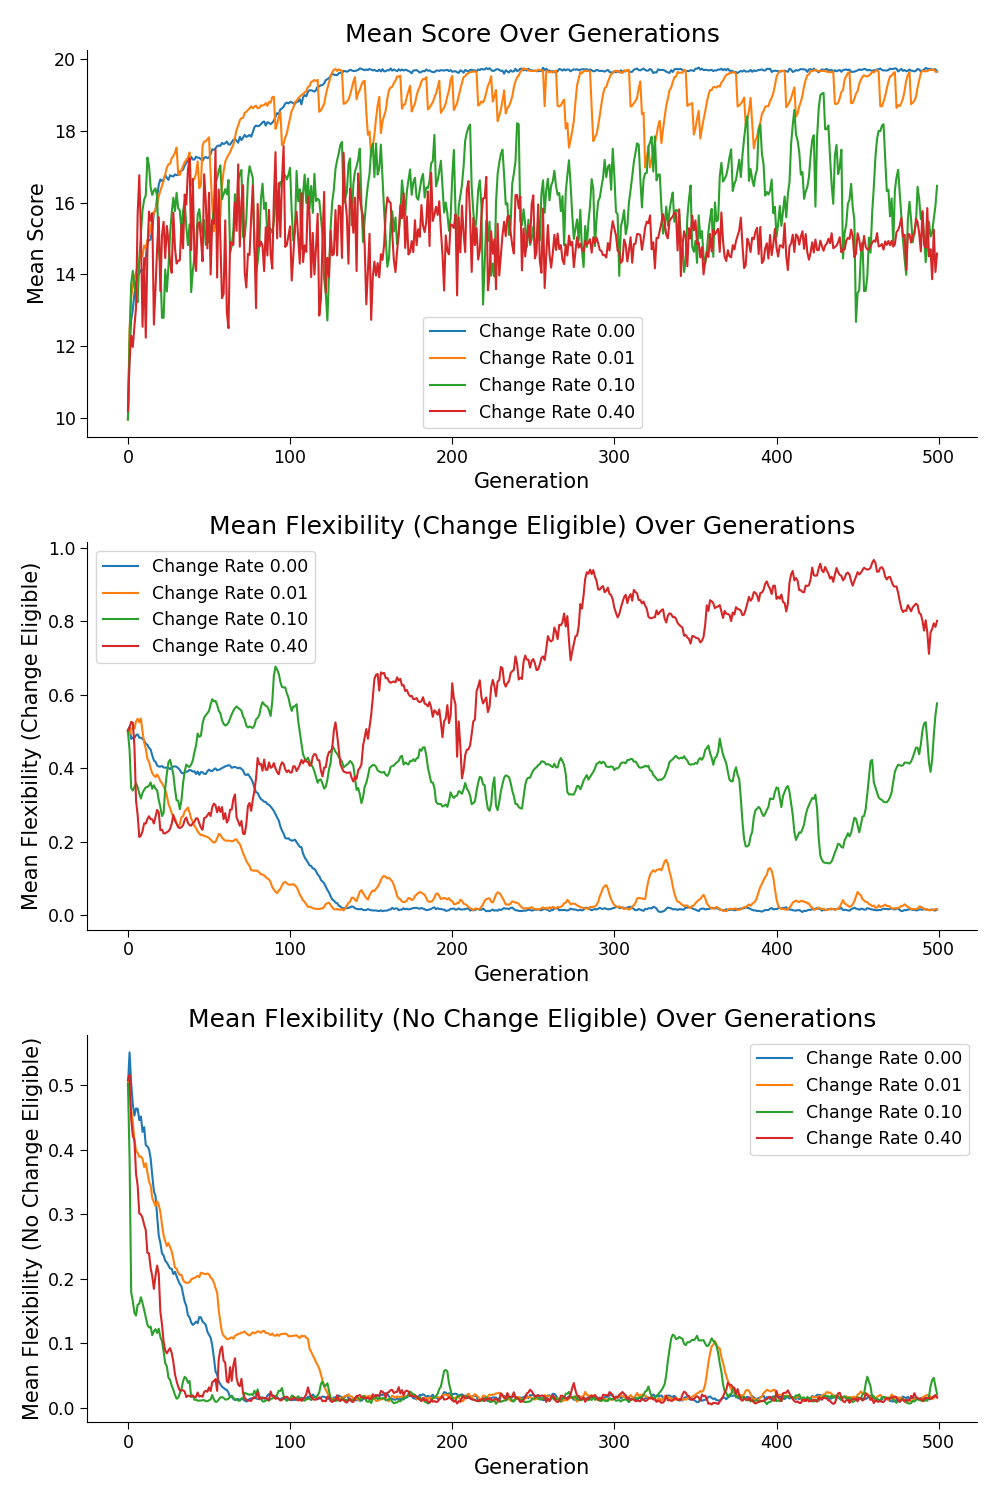

In [8]:
def uncertain_env_learning_simulation(
  pop_size=500, n_gen=500, n_rcpt=20,
  has_changing_environment=True, change_env_prop = 0.5, env_change_rate=1.0,
  has_learning=True, n_learning_trials=1000,
  mutation_rate=0.005, has_mutation=True,
  has_recombination=False, has_assortative_pairing=True,
  selection_type='softmax', #softmax, deterministic truncation, proportional truncation
  softmax_temp=1, truncation_threshold=0.5,
  seed=None, init_pop='simple'):
  """
  Simulates the evolutionary process in a population of genotypes. This function
  models the evolution of genotypes through various mechanisms like learning,
  selection, mutation, recombination, and environmental changes. It is intended
  to explore how populations adapt to dynamic environments.

  Args:
    pop_size (int): Size of the population.
    n_gen (int): Number of generations to simulate.
    n_rcpt (int): Number of receptors/genetic traits in each individual.
    has_changing_environment (bool): If True, the environment changes over generations.
    change_env_prop (float): Proportion of the environment that is subject to change.
    env_change_rate (float): Rate at which the environment changes.
    has_learning (bool): If True, individuals can learn during their lifetime.
    n_learning_trials (int): Number of learning trials per individual.
    mutation_rate (float): Rate of mutation in the population.
    has_mutation (bool): If True, mutations occur in the population.
    has_recombination (bool): If True, recombination occurs during reproduction.
    has_assortative_pairing (bool): If True, assortative mating is used in recombination.
    selection_type (str): Type of selection mechanism used.
    softmax_temp (float): Temperature parameter for softmax selection.
    truncation_threshold (float): Threshold for truncation selection.
    seed (int): Seed for random number generator.
    init_pop (str): Type of initial population ('simple' or 'adapted').

  Returns:
    dict: A dictionary containing historical data of various statistics over generations.
  """
  # Set seed
  rng = np.random.default_rng(seed)

  if not has_learning:
    # with only one trial there is no learning
    n_learning_trials = 1

  # intialize the target connection pattern and how it changes each generation
  env_target = rng.integers(0, 2, size=n_rcpt, dtype=np.bool_)
  env_change_mask = np.zeros(n_rcpt, dtype=np.bool_)
  change_indices = rng.choice(n_rcpt, size=int(change_env_prop*n_rcpt), replace=False)
  env_change_mask[change_indices] = True

  # intialize the population genotypes
  if init_pop == 'simple':
    g_presets = rng.integers(0, 2, size=(pop_size, n_rcpt), dtype=np.bool_)
    g_flexible = rng.integers(0, 2, size=(pop_size, n_rcpt), dtype=np.bool_)
  elif init_pop == 'adapted':
    # For an adapted population, presets match the current environment
    g_presets = np.tile(env_target, (pop_size, 1))  # Replicate env_target for each individual
    g_flexible = np.zeros((pop_size, n_rcpt), dtype=np.bool_)
  population_genome = np.stack((g_presets, g_flexible), axis=2) # pop_size x receptros x 2

  # ensure even divisors/multiples for deterministic truncation
  if selection_type == 'deterministic truncation':
    num_parents = pop_size * (1 - truncation_threshold)
    offspring_per_parent = pop_size / num_parents
    # Check if the numbers are close to integers
    if not (np.isclose(num_parents, np.round(num_parents)) and np.isclose(offspring_per_parent, np.round(offspring_per_parent))):
      print(truncation_threshold)
      print(num_parents)
      print(offspring_per_parent)
      raise ValueError("For deterministic truncation, both pop_size * (1-truncation_threshold) and 1/(1-truncation_threshold) must result in integers.")
    num_parents = int(num_parents)
    offspring_per_parent = int(offspring_per_parent)

  # Track statistics genotypes and scores over generations.
  mean_good_bits_hist = np.zeros(n_gen)
  mean_score_hist = np.zeros(n_gen)
  mean_flexible_change_hist = np.zeros(n_gen)
  mean_flexible_no_change_hist = np.zeros(n_gen)
  var_score_hist = np.zeros(n_gen)
  skew_score_hist = np.zeros(n_gen)
  lower_score_quartile_hist = np.zeros(n_gen)
  upper_score_quartile_hist = np.zeros(n_gen)

  # Helper function calculate score of params against the environmental target
  def score_calc(params, target):
    # params and target both have shape pop_size x n_rcpt
    return np.sum(np.array(params == target, dtype=float), axis=1)

  # Run the simulation
  for generation in range(n_gen):
    # Calculate scores for each genotype
    g_presets = population_genome[:, :, 0]
    g_flexible = population_genome[:, :, 1]
    is_fixed = np.zeros(pop_size, dtype=np.bool_)
    if has_learning:
      best_scores = np.zeros(pop_size)
      cumulative_scores = np.zeros(pop_size)
      best_params = np.copy(g_presets)  # Initially, best parameters are the presets
      composite_params = np.copy(g_presets)  # Initially, composite parameters are the presets
      for t in range(n_learning_trials):
        # Explore only for individuals still learning
        still_learning = ~is_fixed
        still_learning_expanded = still_learning.reshape(pop_size, 1)
        to_update = np.logical_and(still_learning_expanded, g_flexible)
        # Generate new samples only for the part of composite_params to be updated
        update_param_samples = rng.integers(0, 2, size=to_update.sum(), dtype=np.bool_)
        composite_params[to_update] = update_param_samples
        # trial scores are computed for everyhone
        trial_scores = score_calc(composite_params, env_target)
        # but only learners should improve of decline
        improved = trial_scores > best_scores
        declined = trial_scores < best_scores
        best_scores[improved] = trial_scores[improved]
        best_params[improved] = composite_params[improved]  # Update best parameters
        # our learning rule is stop after any improvement
        is_fixed[improved] = True
        # or if things get worse stop exploring and use the known best
        is_fixed[declined] = True
        composite_params[declined] = best_params[declined]
        cumulative_scores += trial_scores
      scores = cumulative_scores / n_learning_trials
    else:
      scores = score_calc(g_presets, env_target)

    # Track statistics of genotype scores over generations.
    mean_ = np.mean(scores)
    var_ = np.var(scores)
    if np.std(scores)>0:
      skew_ = ((pop_size / (pop_size - 1) / (pop_size-2)) *
        (np.sum((scores-np.mean(scores))**3) / np.std(scores)))
    else:
      skew_ = 0
    mean_flexible_change_ = np.mean(np.mean(g_flexible[:, env_change_mask], axis=1))
    mean_flexible_no_change_ = np.mean(np.mean(g_flexible[:, ~env_change_mask], axis=1))
    mean_good_bits_ = np.mean(np.sum(g_presets == env_target, axis=1))

    mean_score_hist[generation] = mean_
    var_score_hist[generation] = var_
    skew_score_hist[generation] = skew_
    lower_score_quartile_hist[generation] = np.percentile(scores, 25)
    upper_score_quartile_hist[generation] = np.percentile(scores, 75)
    mean_flexible_change_hist[generation] = mean_flexible_change_
    mean_flexible_no_change_hist[generation] = mean_flexible_no_change_
    mean_good_bits_hist[generation] = mean_good_bits_

    # Selective Reproduction of different types
    if selection_type == 'proportional':
      pos_scores = np.where(scores < 0, 0, scores)
      if np.sum(scores) > 0:
        prob_scores = pos_scores / np.sum(scores)
      else:
        prob_scores = np.ones_like(scores) / len(scores)
    elif selection_type == 'softmax':
      stabilized_scores = scores - np.max(scores)
      exp_scaled_scores = np.exp(stabilized_scores / softmax_temp)
      prob_scores = exp_scaled_scores / np.sum(exp_scaled_scores)
    elif selection_type == 'proportional truncation':
      pos_scores = np.where(scores < 0, 0, scores)
      trunc_scores = np.zeros_like(scores)
      selected = scores >= np.quantile(scores, truncation_threshold)
      trunc_scores[selected] = pos_scores[selected]
      if np.sum(trunc_scores) > 0:
        prob_scores = trunc_scores / np.sum(trunc_scores)
      else:
        prob_scores = np.ones_like(scores) / len(scores)
    elif selection_type == 'deterministic truncation':
      threshold_score = np.quantile(scores, truncation_threshold)
      # Indices of individuals who meet or exceed the threshold score
      eligible_indices = np.where(scores >= threshold_score)[0]
      # If there are more eligible individuals than needed, select randomly
      # should only be the case for tied scores at the threshold
      if len(eligible_indices) > num_parents:
        selected_indices = rng.choice(eligible_indices, size=num_parents, replace=False)
      else:
        selected_indices = eligible_indices
      # Create the new population
      new_population = []
      for idx in selected_indices:
        new_population.extend([population_genome[idx]] * offspring_per_parent)
      population_genome = np.array(new_population)
    else:
      raise ValueError("Invalid selection_type string, use one of proportional, softmax, proportional truncation, or deterministic truncation")

    if selection_type != 'deterministic truncation':
      # for all other selection types score determines a probability of selection
      selected_indices = rng.choice(pop_size, size=pop_size, p=prob_scores, replace=True)
      population_genome = population_genome[selected_indices]

    # mutation
    if has_mutation:
      mutation_mask = rng.random(population_genome.shape) < mutation_rate
      population_genome ^= mutation_mask

    # recombination
    if has_recombination:
      recombiners = population_genome
      num_recombiners = recombiners.shape[0]

      # Shuffle the indices of the recombing population
      shuffled_indices = rng.permutation(num_recombiners)
      shuffled_recombiners = recombiners[shuffled_indices]
      #mating can be assortative or totally random
      if has_assortative_pairing:
        shuffled_scores = scores[shuffled_indices]
        # Sort the shuffled population based on scores for assortative mating
        sorted_indices = np.argsort(shuffled_scores)
        sorted_recombiners = shuffled_recombiners[sorted_indices]
        # Reshape sorted population to group similar parents into pairs
        parent_pairs = sorted_recombiners.reshape(num_recombiners // 2, 2, n_rcpt, 2)
      else:
        # Reshape shuffled population to group similar parents into pairs
        parent_pairs = shuffled_recombiners.reshape(num_recombiners // 2, 2, n_rcpt, 2)
      # each couple has two kids, with genomes composed of a totally random
      # and independent mix from each parent
      mask1 = rng.integers(0, 2, size=(num_recombiners // 2, n_rcpt, 2)).astype(np.bool_)
      mask2 = rng.integers(0, 2, size=(num_recombiners // 2, n_rcpt, 2)).astype(np.bool_)
      children = np.empty_like(parent_pairs)
      children[:, 0, :, :] = np.where(mask1, parent_pairs[:, 0, :, :], parent_pairs[:, 1, :, :])
      children[:, 1, :, :] = np.where(mask2, parent_pairs[:, 0, :, :], parent_pairs[:, 1, :, :])
      # put the population back into its usual structure, not mated pair structure
      recombined_population = children.reshape(num_recombiners, n_rcpt, 2)
      population = recombined_population

    if has_changing_environment:
      # see which aspect of the environment change and update them
      did_change = env_change_mask & (rng.random(size = env_change_mask.shape) < env_change_rate)
      env_target[did_change] = ~env_target[did_change]

    # repeat the loop for n_gen iterations

  results = {
    'mean_score_hist': mean_score_hist,
    'var_score_hist': var_score_hist,
    'skew_score_hist': skew_score_hist,
    'lower_score_quartile_hist': lower_score_quartile_hist,
    'upper_score_quartile_hist': upper_score_quartile_hist,
    'mean_flexible_change_hist': mean_flexible_change_hist,
    'mean_flexible_no_change_hist': mean_flexible_no_change_hist,
    'mean_good_bits_hist': mean_good_bits_hist
  }
  return results

# Define a range of environmental change rates
env_change_rates =[0.0, 0.01, 0.1, 0.4]

# Initialize dictionaries to store the full histories
score_histories = {rate: [] for rate in env_change_rates}
flexible_change_histories = {rate: [] for rate in env_change_rates}
flexible_no_change_histories = {rate: [] for rate in env_change_rates}

# Run simulations for each change rate
for rate in env_change_rates:
  simulation_results = uncertain_env_learning_simulation(
      env_change_rate=rate,
    )

  # Store the full histories
  score_histories[rate] = simulation_results['mean_score_hist']
  flexible_change_histories[rate] = simulation_results['mean_flexible_change_hist']
  flexible_no_change_histories[rate] = simulation_results['mean_flexible_no_change_hist']

# Plotting using the object-oriented approach
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot Mean Score Histories
for rate, history in score_histories.items():
    axs[0].plot(history, label=f'Change Rate {rate:.2f}')
axs[0].set_xlabel('Generation')
axs[0].set_ylabel('Mean Score')
axs[0].set_title('Mean Score Over Generations')
axs[0].legend()

# Plot Mean Flexibility for Change Eligible Histories
for rate, history in flexible_change_histories.items():
    axs[1].plot(history, label=f'Change Rate {rate:.2f}')
axs[1].set_xlabel('Generation')
axs[1].set_ylabel('Mean Flexibility (Change Eligible)')
axs[1].set_title('Mean Flexibility (Change Eligible) Over Generations')
axs[1].legend()

# Plot Mean Flexibility for No Change Eligible Histories
for rate, history in flexible_no_change_histories.items():
    axs[2].plot(history, label=f'Change Rate {rate:.2f}')
axs[2].set_xlabel('Generation')
axs[2].set_ylabel('Mean Flexibility (No Change Eligible)')
axs[2].set_title('Mean Flexibility (No Change Eligible) Over Generations')
axs[2].legend()

remove_ip_clutter(fig)
plt.tight_layout()
plt.show()

The simulation results above help illustrate how the adaptive balance between learning(plasticity) and genetic determination shifts in response to environmental variability.

In the first plot "Mean Score Over Generations", we see a clear trend: stable environments lead to higher and more rapidly stabilizing mean scores (blue line, change rate = 0.00). As the environment's change rate increases (orange, green, and red lines), mean scores become more erratic and generally lower. This aligns with the expectation that optimization through evolution will always lag behind in dynamic environments where the 'ideal phenotype' can change from generation to generation.

The second plot, "Mean Flexibility (Change Eligible) Over Generations", tracks the evolution of the mean proportion of learning-determined loci, for those loci assocated with fluctuating environmental targets (there are 10 such loci in these particular simulations). The plot shows a higher mean flexibility at loci where environmental targets change frequently (green, 0.1, and red, 0.4 lines) compared to loci with slow or no change (orange, 0.01, and blue, 0.0, lines respectively). This suggests that learning is advantageous and selected for when environmental unpredictability is high, as it gives organisms a way to rapidly adjust to new conditions within their lifetime, and not wholly dependent on genetic changes over generational time. When the environmental volatility is very high (red, 0.4) there is basically no evolutionary tracking of the variable environment, and learning/plasticity dominates. In contrast, at an intermediate level of volatility (grean, 0.1) we see that a combination of adaptive tracking and placticity is stable within the population.

The "Mean Flexibility (No Change Eligible) Over Generations" plot serves as a sanity check, confirming that where environmental targets don't change, learning is selected against. When there is no environmental variability full genetic determination is selected for.

The overarching message from these simulations is clear: genetic determination is beneficial in static environments where the optimal phenotype is constant. In such cases the 'correct phenotype' can in some sense be known fully by the genome and so should simply be developed as rapidly as possible. In such cases learning and other forms of phenotypic plasticity that might slow development have no adaptive value. Conversely, in volatile environments, learning and plasticity can be selected for. Note that in these simulations all of the many mechanisms required for effective plasticity have been abstracted away, e.g. the details of how flexible development/neural plasticity, evaluation of different outcomes, sensing the environment, etc. is achieved is left completely unanswered and so these simulations serve only to hint at the kinds of scenarios when such mechanism could be evolutionarily favoured.



# 1.3.4.1: Some Fitness Score Functions are Hard for Evolution to Optimize

We will continue to use the 'strike-no-strike' decision problem of the last few sequence, but with some added complexity that will help to highlight the adaptive benefits of learning. We still consider an organism with $n$ chemosensory receptors, each corresponding to $n$ possible food/non-food chemical markers in the environment. However, now the functionality of these receptors is determined by $nk$ distinct genetic switches, represented as a bit-string $g$ of length $nk$ with every block of $k$ contiguous 1's corresponding to expression a functioning receptor, and any block with at least one zero corresponding to the abscence of that particular receptor. Now instead of thinking of each genetic bit as corresponding to the expression or absence of a receptor of particular maker, we should instead think of each genetic bit as determining the inclusion of a particular feature critical to the function of a receptor for a some complex marker.

As before we will work with a simplified environment where there is one food item with a marker that consists of $n$ 1's. And as before there are $n$ non-food items that closely mimic this food signal, with each non-food item's marker differing from the food-item marker in exactly one marker/receptor slot. As before a successful strike at edible food yields a reward, $r$ and conversely, a missed strike has a cost, $c$, and the organism's decision rule is to strike only if ***all*** of its receptors pick up a marker and refrains from striking if ***any*** of its receptors are left unactivated.

With this decision rule, in this environment, the organism will always strike at the food-item. Each additional receptor expressed serves to sift out one specific type of non-food item, thereby reducing false positives. As before, singular 'optimal' genotype in this simple environment consists of all 1's. What is different this time is that whereas before having allele '1' instead of '0' at any loci, confered a small, independent, additive benefit to fitness score, now having allele '1' instead of '0' at a given loci, only provides a fitness score benefit if the other $k-1$ loci in that 'receptor block' on the genome also happen to be '1', otherwise the independent effect of that loci is neutral.

Making the same assumptions about the probability of encountering food and non-food items being equal, the number of trails in the strike-no-strike game being large, and the costs and reward being the same and equal to twice the number of receptors divided by the number of trials, the we have the fitness score $z(g)$ given by

$$ z(g):= \sum_{i=0}^{n-1} \prod_{j=1}^{k} g_{j+ik} $$

**Coding Exercise: Implement the new fitness score function.**

Each individual in the population has a genotype $g$, and a resulting score $ z(g):= \sum_{i=0}^{n-1} \prod_{j=1}^{k} g_{j+ik} $, i.e. the number of blocks of entirely 'good bits'. Let's adapt our evolutionary simulation function from before to use this new fitness function:

NotImplementedError: ignored

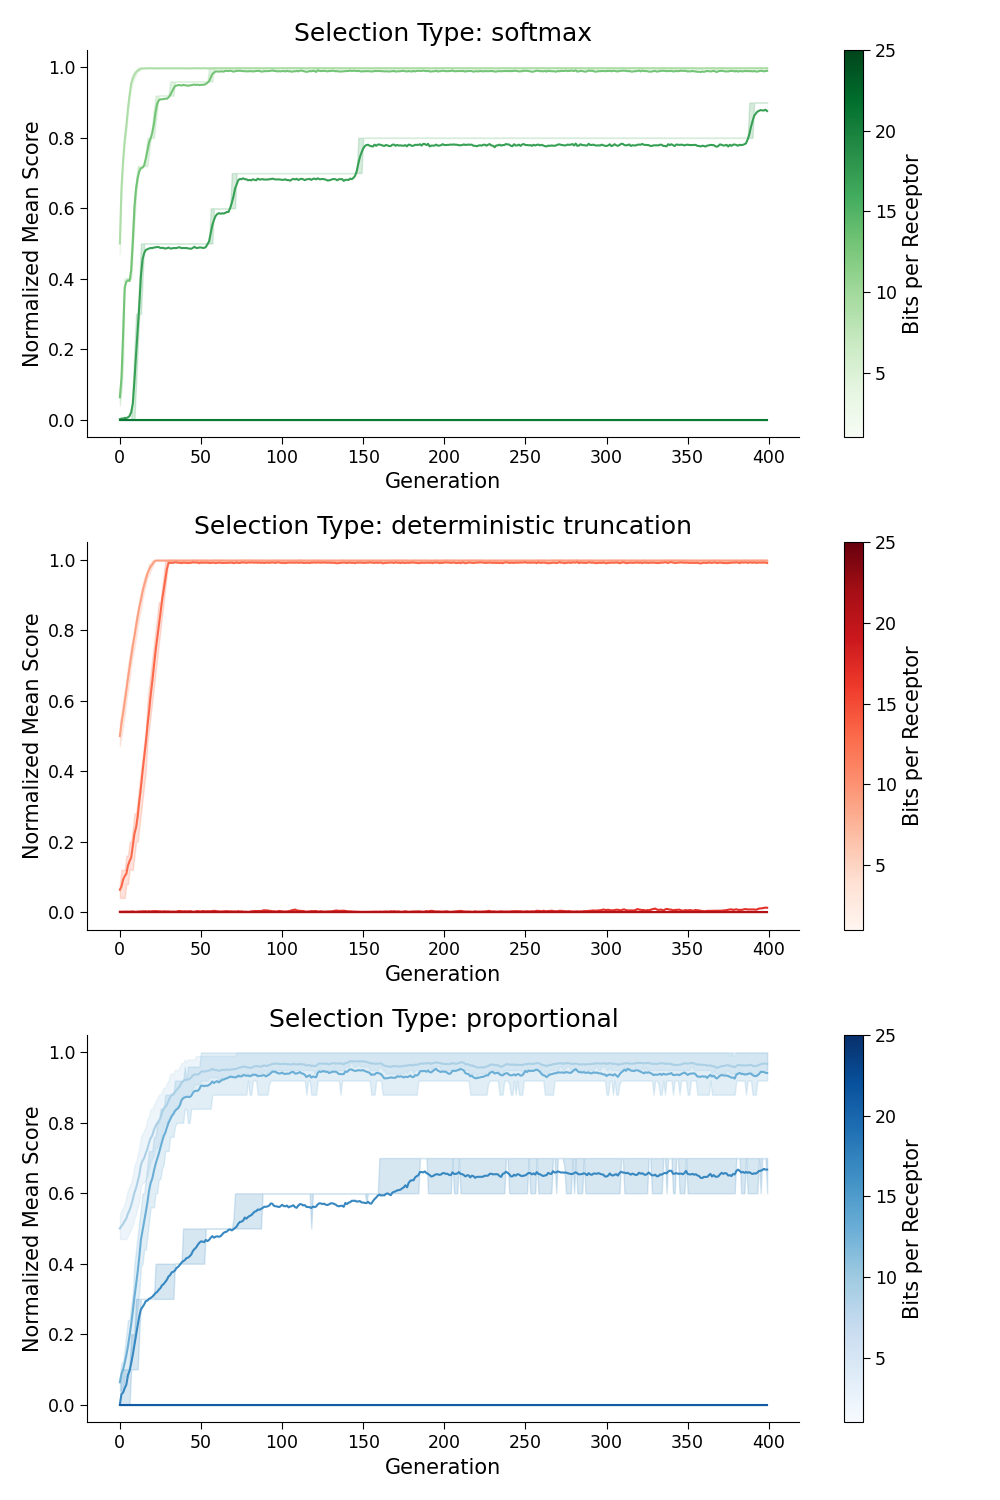

In [5]:
# to_remove solution


def selection_variation_type_simulation(
    pop_size=1000, n_gen=100, n_rcpt=100, n_blocks=1,
    mutation_rate=0.005, has_mutation=True,
    has_distinct_types=False,
    has_recombination=False, has_assortative_pairing=True,
    selection_type='proportional', #softmax, deterministic truncation, proportional truncation
    softmax_temp=1, truncation_threshold=0.5,
    seed=None, init_pop='simple'):
  """
  Simulates the evolutionary process in a population of genotypes playing the
  Strike-No-Strike game using different types of selection.
  """
  # Set seed
  rng = np.random.default_rng(seed)

  # Initialize population
  # To make the computation of our score function easier we structure the
  # population genome as a pop_size x n_rcpt x n_blocks array
  if init_pop == 'simple':
    population = rng.integers(0, 2, size=(pop_size, n_rcpt, n_blocks),
                              dtype=np.bool_)
  elif init_pop == 'adapted':
    population = np.ones((pop_size, n_rcpt, n_blocks), dtype=np.bool_)

  # ensure even divisors/multiples for deterministic truncation
  if selection_type == 'deterministic truncation':
    num_parents = pop_size * (1 - truncation_threshold)
    offspring_per_parent = pop_size / num_parents
    # Check if the numbers are close to integers
    if not (np.isclose(num_parents, np.round(num_parents)) and np.isclose(offspring_per_parent, np.round(offspring_per_parent))):
      print(truncation_threshold)
      print(num_parents)
      print(offspring_per_parent)
      raise ValueError("For deterministic truncation, both pop_size * (1-truncation_threshold) and 1/(1-truncation_threshold) must result in integers.")
    num_parents = int(num_parents)
    offspring_per_parent = int(offspring_per_parent)

  # Track statistics genotype scores over generations.
  mean_hist = np.zeros(n_gen)
  mean_after_sel_hist = np.zeros(n_gen)
  var_hist = np.zeros(n_gen)
  skew_hist = np.zeros(n_gen)
  lower_quartile_hist = np.zeros(n_gen)
  upper_quartile_hist = np.zeros(n_gen)

  # label individuals as recombinors and/or mutators or not
  if has_recombination:
    if has_distinct_types:
      recombination_labels = np.zeros(pop_size, dtype=bool)
      recombination_labels[:pop_size // 2] = True
      rng.shuffle(recombination_labels)
    else:
      recombination_labels = np.ones(pop_size, dtype=bool)
  else:
    recombination_labels = np.zeros(pop_size, dtype=bool)

  if has_mutation:
    if has_distinct_types:
      mutation_labels = np.zeros(pop_size, dtype=bool)
      mutation_labels[:pop_size // 2] = True
      rng.shuffle(mutation_labels)
    else:
      mutation_labels = np.ones(pop_size, dtype=bool)
  else:
    mutation_labels = np.zeros(pop_size, dtype=bool)
  # Track statistics of distinct types if we have them
  if has_distinct_types:
    mutator_non_recombinator = mutation_labels & ~recombination_labels
    recombinator_non_mutator = ~mutation_labels & recombination_labels
    neither = ~mutation_labels & ~recombination_labels
    both = mutation_labels & recombination_labels
    present_types = {
            'mutator_non_recombinator': np.sum(mutator_non_recombinator) > 0,
            'recombinator_non_mutator': np.sum(recombinator_non_mutator) > 0,
            'neither': np.sum(neither) > 0,
            'both': np.sum(both) > 0}
    type_count_hist = {key: np.zeros(n_gen) for key, value in present_types.items() if value}
    type_mean_fitness_hist = {key: np.zeros(n_gen) for key, value in present_types.items() if value}

  # Run the simulation
  for generation in range(n_gen):
    # Calculate scores for each genotype
    ###########################################################################
    # Student exercises in this line on score computation
    ###########################################################################
    scores = np.sum(np.prod(np.array(population, dtype=float), axis=2), axis=1)

    mean_ = np.mean(scores)
    var_ = np.var(scores)
    if np.std(scores)>0:
      skew_ = ((pop_size / (pop_size - 1) / (pop_size-2)) *
        (np.sum((scores-np.mean(scores))**3) / np.std(scores)))
    else:
      skew_ = 0
    # Track statistics genotype scores over generations.
    mean_hist[generation] = mean_
    var_hist[generation] = var_
    skew_hist[generation] = skew_
    lower_quartile_hist[generation] = np.percentile(scores, 25)
    upper_quartile_hist[generation] = np.percentile(scores, 75)

    # Selective Reproduction
    if selection_type == 'proportional':
      pos_scores = np.where(scores < 0, 0, scores)
      if np.sum(scores) > 0:
        prob_scores = pos_scores / np.sum(scores) # this line as exercise
      else:
        prob_scores = np.ones_like(scores) / len(scores)
    elif selection_type == 'softmax':
      stabilized_scores = scores - np.max(scores)
      exp_scaled_scores = np.exp(stabilized_scores / softmax_temp) # this line
      prob_scores = exp_scaled_scores / np.sum(exp_scaled_scores)  # and this line as exercise
    elif selection_type == 'proportional truncation':
      pos_scores = np.where(scores < 0, 0, scores)
      trunc_scores = np.zeros_like(scores)
      selected = scores >= np.quantile(scores, truncation_threshold)
      trunc_scores[selected] = pos_scores[selected]
      if np.sum(trunc_scores) > 0:
        prob_scores = trunc_scores / np.sum(trunc_scores)
      else:
        prob_scores = np.ones_like(scores) / len(scores)
    elif selection_type == 'deterministic truncation':
      # Deterministic truncation selection
      threshold_score = np.quantile(scores, truncation_threshold)
      # Indices of individuals who meet or exceed the threshold score
      eligible_indices = np.where(scores >= threshold_score)[0]
      # If there are more eligible individuals than needed, select randomly
      if len(eligible_indices) > num_parents:
        selected_indices = rng.choice(eligible_indices, size=num_parents, replace=False)
      else:
        selected_indices = eligible_indices
      # Create the new population
      new_population = []
      new_mutation_labels = []
      new_recombination_labels = []
      for idx in selected_indices:
        new_population.extend([population[idx]] * offspring_per_parent)
        if has_mutation:
          new_mutation_labels.extend([mutation_labels[idx]] * offspring_per_parent)
        if has_recombination:
          new_recombination_labels.extend([recombination_labels[idx]] * offspring_per_parent)
      population = np.array(new_population)
      if has_mutation:
        mutation_labels = np.array(new_mutation_labels, dtype=bool)
      if has_recombination:
        recombination_labels = np.array(new_recombination_labels, dtype=bool)
    else:
      raise ValueError("Invalid selection_type string, use one of proportional, softmax, proportional truncation, or deterministic truncation")
    if selection_type != 'deterministic truncation':
      selected_indices = rng.choice(pop_size, size=pop_size, p=prob_scores, replace=True)
      population = population[selected_indices]
      if has_distinct_types:
        if has_mutation:
          mutation_labels = mutation_labels[selected_indices]
        if has_recombination:
          recombination_labels = recombination_labels[selected_indices]

    post_selection_score = np.sum(np.array(population, dtype=float), axis=1)
    mean_after_sel_hist[generation] = np.mean(post_selection_score)

    # track counts and mean fitness score of different types
    if has_distinct_types:
      # Identify each type based on mutation and recombination labels
      mutator_non_recombinator = mutation_labels & ~recombination_labels
      recombinator_non_mutator = ~mutation_labels & recombination_labels
      neither = ~mutation_labels & ~recombination_labels
      both = mutation_labels & recombination_labels
      for type_label, present in present_types.items():
        if present:
          if type_label == 'mutator_non_recombinator':
            type_indices = mutator_non_recombinator
          elif type_label == 'recombinator_non_mutator':
            type_indices = recombinator_non_mutator
          elif type_label == 'neither':
            type_indices = neither
          elif type_label == 'both':
            type_indices = both

          # Count individuals of this type
          type_count_hist[type_label][generation] = np.sum(type_indices)
          # Calculate mean fitness for this type
          if np.any(type_indices):  # To handle division by zero
            type_mean_fitness = np.mean(post_selection_score[type_indices])
          else:
            type_mean_fitness = 0
          type_mean_fitness_hist[type_label][generation] = type_mean_fitness

    # mutation
    if has_mutation:
      if has_distinct_types:
        # Apply mutation only to mutators, identified by mutation_labels
        mutators = population[mutation_labels]
        mutation_mask = rng.random(mutators.shape) < mutation_rate
        mutators ^= mutation_mask
        population[mutation_labels] = mutators
      else:
        # Apply mutation to the entire population
        mutation_mask = rng.random(population.shape) < mutation_rate
        population ^= mutation_mask

    # recombination
    if has_recombination:
      if has_distinct_types:
        recombiners = population[recombination_labels]
        non_recombiners = population[~recombination_labels]
        #make sure even number of recombiners
        if len(recombiners) % 2 != 0:
          # Move the last recombiner to the non-recombiners
          non_recombiners = np.append(non_recombiners, [recombiners[-1]], axis=0)
          recombiners = recombiners[:-1]
        recombiner_mutation_labels = mutation_labels[recombination_labels]
        non_recombiner_mutation_labels = mutation_labels[~recombination_labels]
      else:
        recombiners = population
      num_recombiners = len(recombiners)

      # Shuffle the indices of the recombing population
      shuffled_indices = rng.permutation(num_recombiners)
      shuffled_recombiners = recombiners[shuffled_indices]
      #mating can be assortative or totally random
      if has_assortative_pairing:
        shuffled_scores = np.sum(np.prod(np.array(shuffled_recombiners, dtype=float), axis=2), axis=1)
        # Sort the shuffled population based on scores for assortative mating
        sorted_indices = np.argsort(shuffled_scores)
        sorted_recombiners = shuffled_recombiners[sorted_indices]
        # Reshape sorted population to group similar parents into pairs
        parent_pairs = sorted_recombiners.reshape(num_recombiners // 2, 2, n_rcpt*n_blocks)
      else:
        # Reshape shuffled population to group similar parents into pairs
        parent_pairs = shuffled_recombiners.reshape(num_recombiners // 2, 2, n_rcpt*n_blocks)
      mask1 = rng.integers(0, 2, size=(num_recombiners // 2, n_rcpt*n_blocks)).astype(np.bool_)
      mask2 = rng.integers(0, 2, size=(num_recombiners // 2, n_rcpt*n_blocks)).astype(np.bool_)
      children = np.empty_like(parent_pairs)
      children[:, 0, :] = np.where(mask1, parent_pairs[:, 0, :], parent_pairs[:, 1, :])
      children[:, 1, :] = np.where(mask2, parent_pairs[:, 0, :], parent_pairs[:, 1, :])
      recombined_population = children.reshape(num_recombiners, n_rcpt, n_blocks)
      if has_distinct_types:
        population = np.concatenate([recombined_population, non_recombiners])
        recombiner_labels_bool = np.full(len(recombiners), True, dtype=bool)
        non_recombiner_labels_bool = np.full(len(non_recombiners), False, dtype=bool)
        recombination_labels = np.concatenate([recombiner_labels_bool, non_recombiner_labels_bool])
        if has_mutation:
          mutation_labels = np.concatenate([recombiner_mutation_labels,
                                            non_recombiner_mutation_labels])
      else:
        population = recombined_population



  results = {
    'mean_hist': mean_hist,
    'mean_after_sel_hist': mean_after_sel_hist,
    'var_hist': var_hist,
    'skew_hist': skew_hist,
    'upper_quartile_hist': upper_quartile_hist,
    'lower_quartile_hist': lower_quartile_hist}
  if has_distinct_types:
    results['type_count_hist'] = type_count_hist
    results['type_mean_fitness_hist'] = type_mean_fitness_hist
  return results


def plot_selection_results(ax, selection_type='deterministic_truncation',
                           color='red', label='', seed=123,
                           softmax_temp=1, truncation_threshold=0.5,
                           mutation_rate=0.005, pop_size=100,
                           n_gen=200, n_rcpt=100, n_blocks=1,
                           has_distinct_types=False, has_mutation=False,
                           has_recombination=False, has_assortative_pairing=False,
                           plot_IQR=True, normalize_score=False,
                           init_pop='simple'):
    r = selection_variation_type_simulation(
        selection_type=selection_type,
        n_gen=n_gen,
        n_rcpt=n_rcpt,
        n_blocks=n_blocks,
        seed=seed,
        softmax_temp=softmax_temp,
        truncation_threshold=truncation_threshold,
        mutation_rate=mutation_rate,
        has_distinct_types=has_distinct_types,
        has_mutation=has_mutation,
        has_recombination=has_recombination,
        has_assortative_pairing=has_assortative_pairing,
        pop_size=pop_size,
        init_pop=init_pop)
    generations = np.arange(n_gen)

    if normalize_score:
      mean_hist = r['mean_hist']/n_rcpt
      upper_quartile_hist = r['upper_quartile_hist']/n_rcpt
      lower_quartile_hist = r['lower_quartile_hist']/n_rcpt
    else:
      mean_hist = r['mean_hist']
      upper_quartile_hist = r['upper_quartile_hist']
      lower_quartile_hist = r['lower_quartile_hist']

    # Plot
    if plot_IQR:
      ax.fill_between(generations, upper_quartile_hist, lower_quartile_hist,
                      color=color, alpha=0.2)
    ax.plot(generations, mean_hist, color=color, label=label)

# Parameters
common_params = {
    'n_gen': 400,
    'pop_size': 1000,
    'n_rcpt': 100,
    'n_blocks': 1,
    'init_pop': 'simple',
    'seed': 123,
    'mutation_rate': 0.002,
    'has_mutation': True,
    'has_recombination': True,
    'has_assortative_pairing': True,
    'has_distinct_types': False,
    'normalize_score': True
}

softmax_params = {
    'selection_type': 'softmax',
    'color': 'green',
    'label': 'Softmax',
    'softmax_temp': 1,
}

truncation_params = {
    'selection_type': 'deterministic truncation',
    'color': 'red',
    'label': 'Truncation - 50%',
    'truncation_threshold': 0.5,
}

proportional_params = {
    'selection_type': 'proportional',
    'color': 'blue',
    'label': 'Proportional',
    }

# Create 3x1 subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

selection_types_dicts = [softmax_params, truncation_params, proportional_params]
base_colors = {'proportional': 'Blues', 'deterministic truncation': 'Reds', 'softmax': 'Greens'}

# Define parameter dictionaries for each block size
#vary n_rcpt with n_blocks to keep constant genotype length = n_rcpt * n_blocks
block_sizes = [1, 4, 10, 25]
n_rcpt_size =[100, 25, 10, 4]
block_params = []
for n_blocks, n_rcpt in zip(block_sizes, n_rcpt_size):
  params = {'n_blocks': n_blocks, 'n_rcpt': n_rcpt}
  block_params.append(params)

# Plot for each selection type
for ax, selection_params in zip(axs, selection_types_dicts):
  selection_type = selection_params['selection_type']
  base_color = base_colors[selection_type]
  base = matplotlib.colormaps[base_color]
  num_shades = len(block_sizes)
  colors = [base((i+2)/(num_shades+2)) for i in range(num_shades)]

  for block_param, color in zip(block_params, colors):
    # Combine parameters
    combined_params = {**common_params, **block_param, **selection_params}
    combined_params['color'] = color  # Set the color for block size variation
    combined_params['label'] = f"{selection_params['label']} - Blocks: {block_param['n_blocks']}, Receptors: {block_param['n_rcpt']}"
    plot_selection_results(ax, **combined_params)


  norm = matplotlib.colors.Normalize(vmin=min(block_sizes), vmax=max(block_sizes))
  scalar_mappable = matplotlib.cm.ScalarMappable(norm=norm, cmap=base)

  ax.set_title(f'Selection Type: {selection_type}')
  ax.set_xlabel('Generation')
  ax.set_ylabel('Normalized Mean Score')
  #ax.legend()
  cbar = fig.colorbar(scalar_mappable, ax=ax, orientation='vertical')
  cbar.set_label('Bits per Receptor')

plt.tight_layout()
remove_ip_clutter(fig)
plt.show()

In the simulations above we see the evolution of the (normalized) mean fitness score for different selection types, and different numbers of bit's required per receptor ([1, 4, 10, 25]). In each simulation there is recombination and mutation, but even with both sources of variance available, the evolutionary process is unable to hit upon having all 25 bit's in a receptor align at once. Fitness score functions like this are sometimes reffered to as 'needle-in-a haystack' as there is one correct genetic configuration (all 1's), the needle, hidden among roughly 33.5 million ($2^{25}$) incorrect configurations (in the case where there are 25 genetic bits per receptor), the haystack. What makes this such a challenging problem for an evolutionary process is that all of the incorrect configurations look the same to selection; even though a configuration of one "0" and twenty-four "1's" is very close to the correct configuration in the genome space, from the perspective of selection, this close but wrong configuration is indistinguishable from any other wrong configuration. Selection gives no 'hot' or 'cold' style hints in this case to guide the evolutionary search. This is in stark contrast to the similar problem we looked at in sequence 1.3.2 where selection was sentitive to every changing bit in the genome.



**Math Exercise:**

With some combination of large population size and long time span eventually recombination and mutation will hit upon this rare configuration. Let population size be $N$. Consider a situation where there are $n$ possible receptors, the expression of each determined by $k$ bits in the genome for a total genome size of $nk$.

**Question 1.**

Calculate the approximate probability of an offspring that expresses at least one receptor being born in a population where none of the parents currently express a receptor. Use the following simplifying assumptions and observations:

> - Each bit in a parent is equally likely to be a 1 or a 0. This will be close to true for large populations with some mutation and no selective pressure.
- Mutation can be ignored because it acts symetrically on the bits and we can instead just focus on the variation introduced by recombination.
Hint: Use the first order taylor series approximation for $(1-p)^x$, around $p=0$.

Answer: Each bit in an offspring genome is equally likely to be a 1 or a 0, you can work out all the cases
1. bit comes from parent one and it is a 1 has probability $\frac{1}{4}$.
2. bit comes from parent one and it is a 0 has probability $\frac{1}{4}$.
3. bit comes from parent two and it is a 1 has probability $\frac{1}{4}$.
4. bit comes from parent two and it is a 0 has probability $\frac{1}{4}$.
or you could expand this even further and think about what mutation does or you could play it like a boss mathematician and just say 'by symmetry' (mic drop).

The chance of getting a lucky block of twenty-five ones is $p= \frac{1}{2^k}$.
Each individual has $n$ blocks, and there are $N$ individuals per generation. So the chance of no genetic lottery winners in a generation is $(1-p)^{nN}$. Taking a first-order Taylor series approximation around $p=0$, we have $(1-p)^{nN} \approx 1-nNp$. This approximation is good when $p$ is close to zero, which it is our case since the probability of expressing a receptor is very low. Thus, the chance of at least one winner in a generation is $q\approx 1-(1-nNp)=\frac{nN}{2^k}$.

**Question 2.**

If the probability of a 'genetic lottery winner' in a given generation is $q$, how many generations on average will it take for the evolutionary process to have such a winner. Hint: Look up the Geometric distribution on wikipedia.

Answer: This wait time is geometrically distributed, so the average number of generations will be $\frac{1}{q}$, so the mean number of generations we expect to wait for an 'improved' offspring to appear is approximately $\frac{2^k}{nN}.$

The number of generations required grows exponentially in the number of bits that need to be correct, but only decrease like one over the number of individuals or receptors, so increasing population size is not a scalable solution.

**Bonus Question. **
How many generations will it take if there is no recombination, only mutation?

# 1.3.4.2 Within Lifetime Adaptation

If increasing population size isn't really a viable option for accelerating evolutionary discovery of 'good' parameters for 'difficult' fitness functions (even with recombination). We follow (as does much of this sequence) Hinton and Nolan (1987) and assume that 'learning' is implemented as follows. Instead of each loci in the genome only having two alleles '0' and '1', we now also allow for a third allele '?' which specifies, determined within-lifetime via a learning/development. The '0' and '1' alleles work as before whereas the '?' allele specifies flexible expression which can be either '1' or '0'. It is left to learning/developement to
determine the final 'setting' of these loci. For simplicity, the learning
mechanism simply tries a random combination of settings on each learning trial. If the combination of the flexible and genetically
specified parameters ever produces a payoff that is greater than any of the previous payoffs the settings are frozen. Otherwise they keep changing. This implicitly assumes that the organism can "recognise" when it bas achieved a good setting. This recognition ability (or an ability to tell when the receptor settings have been improved) is required to make learning effective.
(Thus, it is possible that some properties of an organisms behaviour which are currently strongly genetically specified were once learning targets of the organism's ancestors.)

This fit's well with our original cartoon motivation of this problem where a lurking predator decides to strike or not strike over many food /non-food item encounters in it's life. By adding a new set of loci that specify whether expression is 'flexible', we allow organisms with a sub-par geneticly determined behaviour to not be a total dead-weight loss and instead to spend some of their life attempting to improve above their genetically determined baseline. We need to adapt our evolutionary simulation to model this plasticity rule. Let $l$ be the number of learning trials in a lifetime. Formally they

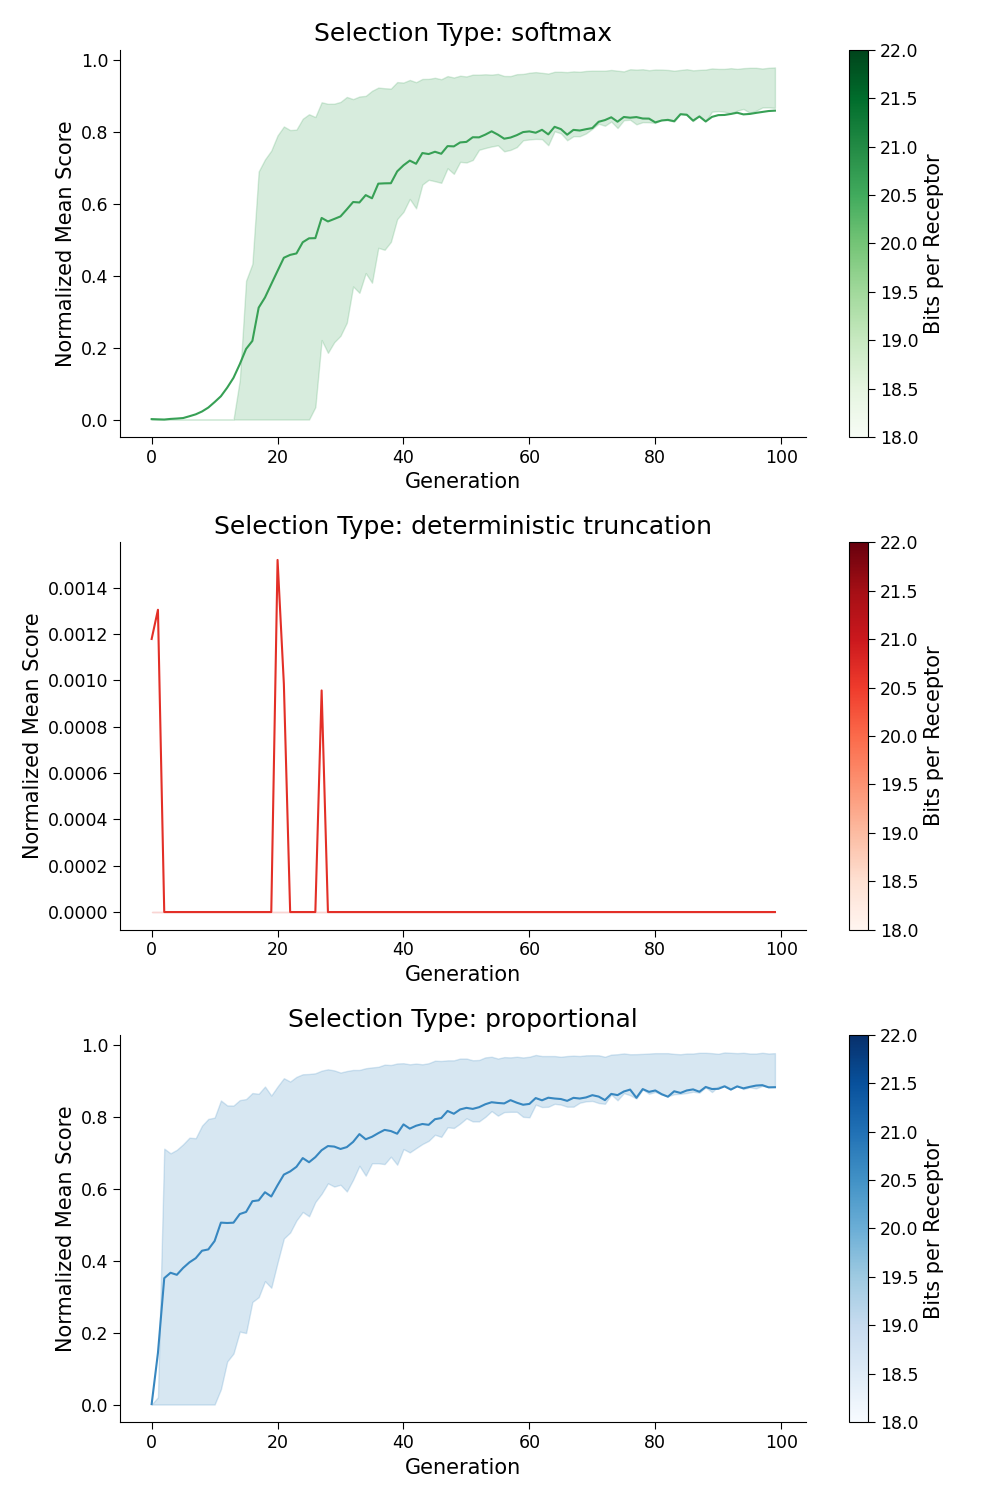

In [17]:
# to_remove solution


def evo_and_learning_simulation(
    pop_size=1000, n_gen=100, n_rcpt=100, n_blocks=1,
    n_learning_trials=10,
    mutation_rate=0.005, has_mutation=True,
    has_recombination=False, has_assortative_pairing=True,
    selection_type='proportional', #softmax, deterministic truncation, proportional truncation
    softmax_temp=1, truncation_threshold=0.5,
    seed=None, init_pop='simple'):
  """
  Simulates the evolutionary process in a population of genotypes playing the
  Strike-No-Strike game using different types of selection.
  """
  # Set seed
  rng = np.random.default_rng(seed)

  # Initialize population
  # To make the computation of our score function easier we structure the
  # population genome as a pop_size x n_rcpt x n_blocks array
  if init_pop == 'simple':
    g_presets = rng.integers(0, 2, size=(pop_size, n_rcpt, n_blocks),
                                          dtype=np.bool_)
    g_flexible = rng.integers(0, 2, size=(pop_size, n_rcpt, n_blocks),
                               dtype=np.bool_)
  elif init_pop == 'adapted':
    g_presets = np.ones((pop_size, n_rcpt, n_blocks), dtype=np.bool_)
    g_flexible = np.zeros((pop_size, n_rcpt, n_blocks), dtype=np.bool_)
  population_genome = np.stack((g_presets, g_flexible), axis=3) # pop_size x receptros x blocks x 2

  # ensure even divisors/multiples for deterministic truncation
  if selection_type == 'deterministic truncation':
    num_parents = pop_size * (1 - truncation_threshold)
    offspring_per_parent = pop_size / num_parents
    # Check if the numbers are close to integers
    if not (np.isclose(num_parents, np.round(num_parents)) and np.isclose(offspring_per_parent, np.round(offspring_per_parent))):
      print(truncation_threshold)
      print(num_parents)
      print(offspring_per_parent)
      raise ValueError("For deterministic truncation, both pop_size * (1-truncation_threshold) and 1/(1-truncation_threshold) must result in integers.")
    num_parents = int(num_parents)
    offspring_per_parent = int(offspring_per_parent)

  # Track statistics genotype scores over generations.
  mean_hist = np.zeros(n_gen)
  mean_after_sel_hist = np.zeros(n_gen)
  var_hist = np.zeros(n_gen)
  skew_hist = np.zeros(n_gen)
  lower_quartile_hist = np.zeros(n_gen)
  upper_quartile_hist = np.zeros(n_gen)

  # Run the simulation
  for generation in range(n_gen):
    g_presets = population_genome[:, :, :, 0]
    g_flexible = population_genome[:, :, :, 1]
    # logic of learning trials
    is_fixed = np.zeros(pop_size, dtype=np.bool_)
    best_scores = np.zeros(pop_size)
    cumulative_scores = np.zeros(pop_size)
    best_params = np.copy(g_presets)  # Initially, best parameters are the presets

    for t in range(n_learning_trials):
      if t == 0:
        # Use the default settings in the first trial
        composite_params = np.copy(g_presets)
        trial_scores = np.sum(np.prod(np.array(composite_params, dtype=float), axis=2), axis=1)
        best_scores = np.copy(trial_scores)
      else:
        # Explore only for individuals still learning
        still_learning = ~is_fixed
        still_learning_expanded = still_learning.reshape(pop_size, 1, 1)
        to_update = np.logical_and(still_learning_expanded, g_flexible)
        # Generate new samples only for the part of composite_params to be updated
        update_param_samples = rng.integers(0, 2, size=to_update.sum(), dtype=np.bool_)
        composite_params[to_update] = update_param_samples
        # trial scores are computed for everyhone
        trial_scores = np.sum(np.prod(composite_params, axis=2), axis=1)
        # but only learners should improve of decline
        improved = trial_scores > best_scores
        declined = trial_scores < best_scores
        best_scores[improved] = trial_scores[improved]
        best_params[improved] = composite_params[improved]  # Update best parameters
        # our learning rule is stop after any improvement
        is_fixed[improved] = True
        # or if things get worse stop exploring and use the known best
        is_fixed[declined] = True
        composite_params[declined] = best_params[declined]

      cumulative_scores += trial_scores
    scores = cumulative_scores / n_learning_trials
    # Calculate population statistics
    mean_ = np.mean(scores)
    var_ = np.var(scores)
    if np.std(scores)>0:
      skew_ = ((pop_size / (pop_size - 1) / (pop_size-2)) *
        (np.sum((scores-np.mean(scores))**3) / np.std(scores)))
    else:
      skew_ = 0
    # Track statistics genotype scores over generations.
    mean_hist[generation] = mean_
    var_hist[generation] = var_
    skew_hist[generation] = skew_
    lower_quartile_hist[generation] = np.percentile(scores, 25)
    upper_quartile_hist[generation] = np.percentile(scores, 75)

    # Selective Reproduction
    if selection_type == 'proportional':
      pos_scores = np.where(scores < 0, 0, scores)
      if np.sum(scores) > 0:
        prob_scores = pos_scores / np.sum(scores) # this line as exercise
      else:
        prob_scores = np.ones_like(scores) / len(scores)
    elif selection_type == 'softmax':
      stabilized_scores = scores - np.max(scores)
      exp_scaled_scores = np.exp(stabilized_scores / softmax_temp) # this line
      prob_scores = exp_scaled_scores / np.sum(exp_scaled_scores)  # and this line as exercise
    elif selection_type == 'proportional truncation':
      pos_scores = np.where(scores < 0, 0, scores)
      trunc_scores = np.zeros_like(scores)
      selected = scores >= np.quantile(scores, truncation_threshold)
      trunc_scores[selected] = pos_scores[selected]
      if np.sum(trunc_scores) > 0:
        prob_scores = trunc_scores / np.sum(trunc_scores)
      else:
        prob_scores = np.ones_like(scores) / len(scores)
    elif selection_type == 'deterministic truncation':
      # Deterministic truncation selection
      threshold_score = np.quantile(scores, truncation_threshold)
      # Indices of individuals who meet or exceed the threshold score
      eligible_indices = np.where(scores >= threshold_score)[0]
      # If there are more eligible individuals than needed, select randomly
      if len(eligible_indices) > num_parents:
        selected_indices = rng.choice(eligible_indices, size=num_parents, replace=False)
      else:
        selected_indices = eligible_indices
      # Create the new population
      new_population = []
      for idx in selected_indices:
        new_population.extend([population_genome[idx]] * offspring_per_parent)
      population_genome = np.array(new_population)
    else:
      raise ValueError("Invalid selection_type string, use one of proportional, softmax, proportional truncation, or deterministic truncation")

    # sample the new population unless using deterministic truncation
    if selection_type != 'deterministic truncation':
      selected_indices = rng.choice(pop_size, size=pop_size, p=prob_scores, replace=True)
      population_genome = population_genome[selected_indices]

    # mutation
    if has_mutation:
      mutation_mask = rng.random(population_genome.shape) < mutation_rate
      population_genome ^= mutation_mask

    # recombination
    if has_recombination:
      recombiners = population_genome
      num_recombiners = recombiners.shape[0]

      # Shuffle the indices of the recombing population
      shuffled_indices = rng.permutation(num_recombiners)
      shuffled_recombiners = recombiners[shuffled_indices]
      #mating can be assortative or totally random
      if has_assortative_pairing:
        shuffled_scores = scores[shuffled_indices]
        # Sort the shuffled population based on scores for assortative mating
        sorted_indices = np.argsort(shuffled_scores)
        sorted_recombiners = shuffled_recombiners[sorted_indices]
        # Reshape sorted population to group similar parents into pairs
        parent_pairs = sorted_recombiners.reshape(num_recombiners // 2, 2, n_rcpt*n_blocks*2)
      else:
        # Reshape shuffled population to group similar parents into pairs
        parent_pairs = shuffled_recombiners.reshape(num_recombiners // 2, 2, n_rcpt*n_blocks*2)
      mask1 = rng.integers(0, 2, size=(num_recombiners // 2, n_rcpt*n_blocks*2)).astype(np.bool_)
      mask2 = rng.integers(0, 2, size=(num_recombiners // 2, n_rcpt*n_blocks*2)).astype(np.bool_)
      children = np.empty_like(parent_pairs)
      children[:, 0, :] = np.where(mask1, parent_pairs[:, 0, :], parent_pairs[:, 1, :])
      children[:, 1, :] = np.where(mask2, parent_pairs[:, 0, :], parent_pairs[:, 1, :])
      recombined_population = children.reshape(num_recombiners, n_rcpt, n_blocks, 2)
      population = recombined_population

  results = {
    'mean_hist': mean_hist,
    'mean_after_sel_hist': mean_after_sel_hist,
    'var_hist': var_hist,
    'skew_hist': skew_hist,
    'upper_quartile_hist': upper_quartile_hist,
    'lower_quartile_hist': lower_quartile_hist}

  return results


def plot_evo_learn_results(ax=ax, color='red', label='', plot_IQR=True,
                           normalize_score=False, seed=123,
                           selection_type='deterministic_truncation',
                           softmax_temp=1, truncation_threshold=0.5,
                           pop_size=1000, n_gen=20, n_rcpt=100, n_blocks=1,
                           n_learning_trials=1000,
                           has_mutation=True, mutation_rate=0.005,
                           has_recombination=True, has_assortative_pairing=True,
                           init_pop='simple'):
    r = evo_and_learning_simulation(
        selection_type=selection_type,
        softmax_temp=softmax_temp,
        truncation_threshold=truncation_threshold,
        pop_size=pop_size,
        n_gen=n_gen,
        n_rcpt=n_rcpt,
        n_blocks=n_blocks,
        n_learning_trials=n_learning_trials,
        seed=seed,
        has_mutation=has_mutation,
        mutation_rate=mutation_rate,
        has_recombination=has_recombination,
        has_assortative_pairing=has_assortative_pairing,
        init_pop=init_pop)
    generations = np.arange(n_gen)

    if normalize_score:
      mean_hist = r['mean_hist']/n_rcpt
      upper_quartile_hist = r['upper_quartile_hist']/n_rcpt
      lower_quartile_hist = r['lower_quartile_hist']/n_rcpt
    else:
      mean_hist = r['mean_hist']
      upper_quartile_hist = r['upper_quartile_hist']
      lower_quartile_hist = r['lower_quartile_hist']

    # Plot
    if plot_IQR:
      ax.fill_between(generations, upper_quartile_hist, lower_quartile_hist,
                      color=color, alpha=0.2)
    ax.plot(generations, mean_hist, color=color, label=label)

# Parameters
common_params = {
    'n_gen': 100,
    'pop_size': 1000,
    'n_rcpt': 20,
    'n_blocks': 1,
    'n_learning_trials':1000,
    'init_pop': 'simple',
    'seed': 123,
    'mutation_rate': 0.002,
    'has_mutation': True,
    'has_recombination': True,
    'has_assortative_pairing': True,
    'normalize_score': True
}

softmax_params = {
    'selection_type': 'softmax',
    'color': 'green',
    'label': 'Softmax',
    'softmax_temp': 1,
}

truncation_params = {
    'selection_type': 'deterministic truncation',
    'color': 'red',
    'label': 'Truncation - 50%',
    'truncation_threshold': 0.5,
}

proportional_params = {
    'selection_type': 'proportional',
    'color': 'blue',
    'label': 'Proportional',
    }

# Create 3x1 subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

selection_types_dicts = [softmax_params, truncation_params, proportional_params]
base_colors = {'proportional': 'Blues', 'deterministic truncation': 'Reds', 'softmax': 'Greens'}

# Define parameter dictionaries for each block size
#vary n_rcpt with n_blocks to keep constant genotype length = n_rcpt * n_blocks
block_sizes = [20]
n_rcpt_size =[1]
block_params = []
for n_blocks, n_rcpt in zip(block_sizes, n_rcpt_size):
  params = {'n_blocks': n_blocks, 'n_rcpt': n_rcpt}
  block_params.append(params)

# Plot for each selection type
for ax, selection_params in zip(axs, selection_types_dicts):
  selection_type = selection_params['selection_type']
  base_color = base_colors[selection_type]
  base = matplotlib.colormaps[base_color]
  num_shades = len(block_sizes)
  colors = [base((i+2)/(num_shades+2)) for i in range(num_shades)]

  for block_param, color in zip(block_params, colors):
    # Combine parameters
    combined_params = {**common_params, **block_param, **selection_params}
    combined_params['color'] = color  # Set the color for block size variation
    combined_params['label'] = f"{selection_params['label']} - Blocks: {block_param['n_blocks']}, Receptors: {block_param['n_rcpt']}"
    plot_evo_learn_results(ax, **combined_params)


  norm = matplotlib.colors.Normalize(vmin=min(block_sizes), vmax=max(block_sizes))
  scalar_mappable = matplotlib.cm.ScalarMappable(norm=norm, cmap=base)

  ax.set_title(f'Selection Type: {selection_type}')
  ax.set_xlabel('Generation')
  ax.set_ylabel('Normalized Mean Score')
  #ax.legend()
  #cbar = fig.colorbar(scalar_mappable, ax=ax, orientation='vertical')
  #cbar.set_label('Bits per Receptor')

plt.tight_layout()
remove_ip_clutter(fig)
plt.show()

Both 'softmax' and 'deterministic truncation' selection are able to drive the populations score up to the 'perfect' score of 100, but 'proportional' selection does not. What is going on here?

As the average score of the population increases, the **relative** fitness advantage of an additional 'score point' becomes very slight, so slight that the 'signal' from the environment becomes overwhelmed by the stochasticity in selection. A larger population can serve as a partial counter to this stochasticity allowing weakly selected traits to become dominant in a population. Note that in our model truncation selection is deterministic and assumes that individuals can be perfectly sorted by score. In reality even if 'survival of the fittest' style selection is being applied, there is always the possibility of some 'error in measurement' whether that be by the breeder or the environment. All this to show that strength of selection is really important in determining how quickly, in terms of generations, a good solution is found.

Both truncation selection and softmax selection have a natural 'strength of selection' scaling parameters, the truncation threshold and the softmax temperature respectively. Set these parameters in code snippet below and see if you can make truncation selection faster than softmax selection in our simulation.

In [ ]:
2**25

In [ ]:
################################################################################
# TODO for students: Set the softmax temperature and truncation threshold
# parameters in such a way that truncation selection is faster than
# softmax selection.
raise NotImplementedError("Exercise: make truncation faster than softmax")
################################################################################

fig, ax = plt.subplots(figsize=(10, 4))

softmax_params = {
    'selection_type': 'softmax',
    'color': 'green',
    'label': 'Softmax',
    'softmax_temp': ...,
}
truncation_params = {
    'selection_type': 'deterministic truncation',
    'color': 'red',
    'label': 'Truncation',
    'truncation_threshold': ...,
}

plot_selection_results(ax, **softmax_params, **common_params)
plot_selection_results(ax, **truncation_params, **common_params)

ax.set_xlabel('Generation')

ax.set_xlabel('Generation')
ax.set_ylabel('Population Score\nMean+IQR')
ax.set_title('Comparison of Selection Types over Generations')
ax.legend()

remove_ip_clutter(fig)
plt.show()

In [ ]:
# to_remove solution

fig, ax = plt.subplots(figsize=(10, 4))

softmax_params = {
    'selection_type': 'softmax',
    'color': 'green',
    'label': 'Softmax',
    'softmax_temp': 7,
}
truncation_params = {
    'selection_type': 'deterministic truncation',
    'color': 'red',
    'label': 'Truncation',
    'truncation_threshold': .9,
}

plot_selection_results(ax, **softmax_params, **common_params)
plot_selection_results(ax, **truncation_params, **common_params)

ax.set_xlabel('Generation')

ax.set_xlabel('Generation')
ax.set_ylabel('Population Score\nMean+IQR')
ax.set_title('Comparison of Selection Types over Generations')
ax.legend()

remove_ip_clutter(fig)
plt.show()

Question:

1. Is there a relationship between the speed at which different selection types reach the optimal genotype and the variance in population score, as indicated by the relative width of the shaded interquartile regions in the figures above? [Answer](## 'Yes, stronger forms of selection, i.e. those that achieve the optimal genotype more quickly, tend to have less variation in the population score.')



In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M1")

# 1.3.1.2: Mutation Rate, Population Size and Rate of Adaptation

So now we know that strength of selection is important, what about population size and mutation? Let's simulate and see! Mutation rate first. While you're waiting for the simulations to run, think about think about what different mutation rates might do to the speed of the evolutionary process.

In [ ]:
#@markdown **Run this cell** to use the simulation method we created above to explore how mutation rate impacts rate of evolution for different kinds of selection.

# simulation and plotting functions defined here again in case coding exercise
# not completed

def selection_type_simulation(pop_size=1000, n_gen=100, n_rcpt=100,
                              mutation_rate=0.005, has_mutation=True,
                              has_recombination=False, has_assortative_pairing=True,
                              selection_type='proportional', #softmax, deterministic truncation, proportional truncation
                              softmax_temp=1, truncation_threshold=0.5,
                              seed=None, init_pop='simple'): # mutation_eq, recomb_eq
  """
  Simulates the evolutionary process in a population of genotypes playing the
  Strike-No-Strike game using different types of selection.
  """
  # Set seed
  rng = np.random.default_rng(seed)

  # Initialize population
  if init_pop == 'simple':
    population = rng.integers(0, 2, size=(pop_size, n_rcpt),
                              dtype=np.bool_)
  elif init_pop != 'simple':
    # for agreement with theoretical models we initialize population so that
    # variance starts at 'dynamic equilibrium' level
    if init_pop == 'mutation_eq':
      # Calculate n' and b
      n_prime = int(2 * mutation_rate * n_rcpt * (np.pi - 2))
      b = int(n_rcpt * (-2 * np.pi * mutation_rate + 4 * mutation_rate + 1) / 2)
    elif init_pop == 'recomb_eq':
      n_prime = int(n_rcpt*(np.pi - 2) / (2 + np.pi))
      b = int(2 * n_rcpt / (2 + np.pi))
    # Generate shifted binomial distribution
    num_ones = rng.binomial(n_prime, 0.5, size=pop_size) + b
    population = np.zeros((pop_size, n_rcpt), dtype=np.bool_)
    # Assign '1's randomly for each population member
    for i in range(pop_size):
      one_positions = rng.choice(n_rcpt, num_ones[i], replace=False)
      population[i, one_positions] = True

  # Track statistics genotype scores over generations.
  mean_hist = np.zeros(n_gen)
  mean_after_sel_hist = np.zeros(n_gen)
  var_hist = np.zeros(n_gen)
  skew_hist = np.zeros(n_gen)
  lower_quartile_hist = np.zeros(n_gen)
  upper_quartile_hist = np.zeros(n_gen)

  for generation in range(n_gen):
    # Calculate scores for each genotype
    scores = np.sum(np.array(population, dtype=float), axis=1)

    mean_ = np.mean(scores)
    var_ = np.var(scores)
    if np.std(scores)>0:
      skew_ = ((pop_size / (pop_size - 1) / (pop_size-2)) *
        (np.sum((scores-np.mean(scores))**3) / np.std(scores)))
    else:
      skew_ = 0
    # Track statistics genotype scores over generations.
    mean_hist[generation] = mean_
    var_hist[generation] = var_
    skew_hist[generation] = skew_
    lower_quartile_hist[generation] = np.percentile(scores, 25)
    upper_quartile_hist[generation] = np.percentile(scores, 75)

    # Calculate fitness for each genotype

    # Selective Reproduction
    if selection_type == 'proportional':
      pos_scores = np.where(scores < 0, 0, scores)
      if np.sum(scores) > 0:
        prob_scores = pos_scores / np.sum(scores) # this line as exercise
      else:
        prob_scores = np.ones_like(scores) / len(scores)
    elif selection_type == 'softmax':
      stabilized_scores = scores - np.max(scores)
      exp_scaled_scores = np.exp(stabilized_scores / softmax_temp) # this line
      prob_scores = exp_scaled_scores / np.sum(exp_scaled_scores)  # and this line as exercise
    elif selection_type == 'proportional truncation':
      pos_scores = np.where(scores < 0, 0, scores)
      trunc_scores = np.zeros_like(scores)
      selected = scores >= np.quantile(scores, truncation_threshold)
      trunc_scores[selected] = pos_scores[selected]
      if np.sum(trunc_scores) > 0:
        prob_scores = trunc_scores / np.sum(trunc_scores)
      else:
        prob_scores = np.ones_like(scores) / len(scores)
    elif selection_type == 'deterministic truncation':
      # Deterministic truncation selection
      selected = scores >= np.quantile(scores, truncation_threshold) # this line as exercise
      selected_indices = np.arange(len(scores))[selected]
      # Create the new population
      new_population = []
      base_replication_count = int(pop_size / len(selected_indices))
      additional_replications = pop_size % len(selected_indices)
      for idx in selected_indices:
        new_population.extend([population[idx]] * base_replication_count) # this line as exercise
      # If there are additional replications needed, add the highest scoring individuals
      if additional_replications > 0:
        sorted_selected_indices = selected_indices[np.argsort(-scores[selected])]
        new_population.extend([population[idx] for idx in sorted_selected_indices[:additional_replications]])
      population = np.array(new_population)
    else:
      raise ValueError("Invalid selection_type string, use one of proportional, softmax, proportional truncation, or deterministic truncation")
    if selection_type != 'deterministic truncation':
      population = rng.choice(population, size=pop_size, p=prob_scores) # this line as exercise

    post_selection_score = np.sum(np.array(population, dtype=float), axis=1)
    mean_after_sel_hist[generation] = np.mean(post_selection_score)

    # mutation
    if has_mutation:
      mutation_mask = rng.random(population.shape) < mutation_rate
      population ^= mutation_mask

    # recombination
    if has_recombination:
      # Shuffle the indices of the population
      shuffled_indices = rng.permutation(pop_size)
      shuffled_population = population[shuffled_indices]
      #mating can be assortative or totally random
      if has_assortative_pairing:
        shuffled_scores = np.sum(np.array(shuffled_population, dtype=float), axis=1)
        # Sort the shuffled population based on scores for assortative mating
        sorted_indices = np.argsort(shuffled_scores)
        sorted_population = shuffled_population[sorted_indices]
        # Reshape sorted population to group similar parents into pairs
        parent_pairs = sorted_population.reshape(pop_size // 2, 2, n_rcpt)
      else:
        # Reshape shuffled population to group similar parents into pairs
        parent_pairs = shuffled_population.reshape(pop_size // 2, 2, n_rcpt)

      # The rest of your recombination process remains the same
      mask1 = rng.integers(0, 2, size=(pop_size // 2, n_rcpt)).astype(np.bool_)
      mask2 = rng.integers(0, 2, size=(pop_size // 2, n_rcpt)).astype(np.bool_)

      children = np.empty_like(parent_pairs)
      children[:, 0, :] = np.where(mask1, parent_pairs[:, 0, :], parent_pairs[:, 1, :])
      children[:, 1, :] = np.where(mask2, parent_pairs[:, 0, :], parent_pairs[:, 1, :])

      population = children.reshape(pop_size, n_rcpt)

  return mean_hist, mean_after_sel_hist, var_hist, skew_hist, upper_quartile_hist, lower_quartile_hist


def plot_selection_results(ax, selection_type, n_gen, color, label, seed,
                           softmax_temp=1, truncation_threshold=0.5,
                           mutation_rate=0.005, pop_size=1000,
                           plot_IQR=True, init_pop='simple'):
    (mean_hist, mean_after_sel_hist, var_hist, skew_hist,
     upper_quartile_hist, lower_quartile_hist) = selection_type_simulation(
        selection_type=selection_type,
        n_gen=n_gen,
        seed=seed,
        softmax_temp=softmax_temp,
        truncation_threshold=truncation_threshold,
        mutation_rate=mutation_rate,
        pop_size=pop_size,
        init_pop=init_pop
    )
    generations = np.arange(n_gen)
    if plot_IQR:
      ax.fill_between(generations, lower_quartile_hist, upper_quartile_hist,
                      color=color, alpha=0.2)
    ax.plot(generations, mean_hist, color=color, label=label)




# Parameters
n_gen = 200
seed = 123
mutation_rates = [0.00, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]  # Example mutation rates
pop_size = 1000  # Example population size

# Create 3x1 subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot for each selection type
selection_types = ['softmax', 'deterministic truncation', 'proportional']
base_colors = {'proportional': 'Blues', 'deterministic truncation': 'Reds', 'softmax': 'Greens'}
for ax, selection_type in zip(axs, selection_types):
  base_color = base_colors[selection_type]
  base = matplotlib.colormaps[base_color]
  num_shades = len(mutation_rates)
  colors = [base((i+1)/(num_shades+1)) for i in range(num_shades)]

  norm = matplotlib.colors.Normalize(vmin=min(mutation_rates), vmax=max(mutation_rates))
  scalar_mappable = matplotlib.cm.ScalarMappable(norm=norm, cmap=base)

  for mutation_rate, color in zip(mutation_rates, colors):
    label = f'Mutation Rate {mutation_rate}'
    plot_selection_results(ax, selection_type, n_gen, color, label, seed,
                           mutation_rate=mutation_rate, pop_size=pop_size,
                           plot_IQR=False)

  ax.set_title(f'Selection Type: {selection_type}')
  ax.set_xlabel('Generation')
  ax.set_ylabel('Population Mean Score')
  #ax.legend()
  cbar = fig.colorbar(scalar_mappable, ax=ax, orientation='vertical')
  cbar.set_label('Mutation Rate')

plt.tight_layout()
remove_ip_clutter(fig)
plt.show()

Across all three selection types we observe a similar pattern. Very high mutation rates (darker shades) lower the final average population score and prevent the optimal genotype from being achieved. In these cases selection can not sort through all the new variation mutation is generating fast enough to maintain a high population score. In contrast lower mutation rates result in a higher final average score, but if the mutation rate is very low, it can take longer for the evolutionary process to find the optimal solution. In this case the rate of introduction of new variation to be tested by selection is constraining and slowing down the process. This is seen most clearly in the case when there is no mutation, and the population converges on one of the best genotypes in the initial population, but can improve no further once that initial variation is used up. So both too little and too much mutation can result in a slower optimization. Evolutionary processes need some but not too much mutation to effectively find optimal solutions.

Now let's take a look at the impact of population size. While you're waiting for the simulations to run, think about what different population sizes might do to the speed of the evolutionary process.

In [ ]:
#@markdown **Run this cell** to use the simulation method we created above to explore how population size impacts rate of evolution for different kinds of selection.


# Parameters
n_gen = 200
seed = 123
population_sizes = [10, 50, 100, 500, 1000, 5000]  # Example population sizes

# Create 3x1 subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot for each selection type
selection_types = ['softmax', 'deterministic truncation', 'proportional']
base_colors = {'proportional': 'Blues', 'deterministic truncation': 'Reds', 'softmax': 'Greens'}

for ax, selection_type in zip(axs, selection_types):
  base_color = base_colors[selection_type]
  base = matplotlib.colormaps[base_color]
  num_shades = len(population_sizes)
  colors = [base((i+1)/(num_shades+1)) for i in range(num_shades)]

  norm = matplotlib.colors.Normalize(vmin=min(population_sizes), vmax=max(population_sizes))
  scalar_mappable = matplotlib.cm.ScalarMappable(norm=norm, cmap=base)

  for pop_size, color in zip(population_sizes, colors):
    label = f'Pop Size {pop_size}'
    plot_selection_results(ax, selection_type, n_gen, color, label, seed,
                           pop_size=pop_size, plot_IQR=False)

  ax.set_title(f'Selection Type: {selection_type}')
  ax.set_xlabel('Generation')
  ax.set_ylabel('Population Mean Score')
  cbar = fig.colorbar(scalar_mappable, ax=ax, orientation='vertical')
  cbar.set_label('Population Size')

plt.tight_layout()
remove_ip_clutter(fig)
plt.show()

In every selection process, a very small population slows the improvement of the population score. And for proportional selection, small population basically halts progression (weak selection cannot overcome genetic drift). However, beyond a critical population size, further increases in population size seem to barely affect the rate of adaptation. This phenomenon is rooted in the fundamental nature of selection, which acts on the heritable variation of traits within a population. Beyond a certain threshold, a larger population size doesn't provide (meaningfully) more variation. To understand this, consider the effect of sample size on estimates of variance in statistics: The variance of a sample is defined as $\frac{1}{N} \sum_{i=1}^{N}(x_i - \bar{x})^2$ where $\bar{x}$ is the sample mean. Using this raw, or empirical variance, will provide a biased (under) estimate of the true variance of the underlying random variable, which is why $\frac{1}{N-1} \sum_{i=1}^{N-1}(x_i - \bar{x})^2$ is used as an estimate for the true variance. The difference between $\frac{1}{N-1} - \frac{1}{N}$ is on the order of $\frac{1}{N^2}$. Similarly, incremental increase in variation for selection to act on provided by additional individuals diminishes rapidly. Only very small population sizes significantly limit variation reduce the efficiency of the selection process.

In the case of proportional selection, where the strength of selection is weak, a large population does appear to accelerate adaptation, however this has more to do with a large population size counteracting the stochasticity introduced by random drift.


In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M2")

# 1.3.1.3 Model of Selection

We have mentioned already that selection acts on heritable variation. The following analyses aims to solidify and make clear precisely what is meant by this statement.

Suppose that the score $z(t)$ is normally distributed in the population at generation $t$ with mean $\mu(t)$ and variance $\sigma^2(t)$, and that as in our simulations, the trait $z$ is perfectly passed on from parent to offspring (if there is no mutation). Then we can ask what will the mean $\mu(t+1)$ and variance $\sigma^2(t+1)$ of the child population look like after one generation of truncation selection (with truncation threshold 0.5). For a normal distribution it is known (and easy but tedious to work out) that when taking the top half of a normal distribution the resulting mean and variance of the new distribution are given by:

$$ \mu(t+1) = \mu(t) + \sqrt{\frac{2}{\pi}} \sigma(t)$$
and
$$ \sigma^2(t+1) = \sigma^2(t) \left(1-\frac{2}{\pi}\right).$$

Immediately we can see that selection is increasing the mean value of the trait by an amount proportional to the standard deviation (the root of the variance) in the trait, while simultaneously decreasing the variation in the trait by an amount that is also proportional (with a different constant) to the existing variation in the trait.

A similar pattern holds for proportional selection and can be derived (with some effort) from the definitions of mean, variance and skew.

$$ \mu(t+1) = \mu(t) + \frac{\sigma^2(t)}{\mu(t)}$$
and
$$ \sigma^2(t+1) = \sigma^2(t) \left(1 + \frac{\gamma(t) \sigma(t)}{\mu(t)} -\frac{\sigma^2(t)}{\mu(t)^2}\right) $$

Here $\gamma(t)$ is the skew in the population distribution of $z$ at generation $t$. Although the details are different we see that again selection is increasing the mean value of the trait by an amount proportional to the variance of the trait, and decreasing the variance by an amount proportional to the variance. Variation can also be increased or decreased depending on the skew of the distribution. If the population is skewed in the direction of selection ($\gamma >0$), i.e. there is a thicker tail on the right, then selection will increase the frequency of these rare variants which will contribute to an increase in variation. In contrast if the population is skewed to so that the tail is thicker on the left ($\gamma < 0$) selection will decrease the frequency of these rare variants and thereby further reduce variation.

We can also see that unlike the truncation selection case, with proportional selection these increments are scaled by the population mean $\mu$ showing how the strength of selection diminishes as the baseline score becomes greater.

**Bonus Exercise:**
Derive the formulas given above for the change in mean and variance due to truncation and proportional selection.

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M3")

# 1.3.1.4 Model of Mutation

From the above it is clear that selection can be viewed as a process that increases the average fitness score (average fitness in the strict relative sense is always constant) proportional to the existing variation in the population while simultaneously decreasing the population variation in fitness score. If selection is the engine of evolution, variation is the fuel. Mutation is one way in which new variation can be injected into the population, and as we saw in the simulations of the previous section when mutation is set to zero and no new variation in introduced the evolutionary processes grinds to a halt.  As we did above with selection, let's think about what the effects of mutation are on the mean and variance of the score distribution $z$ from one generation to the next.

If a parent has score $z$, and $m$ is the per bit mutation rate and $n$ is the total number of bits in the part of the genotype being modeled, then, with mutation the child score will be the sum of the parent's $z$ value less the number of 'good' bits, there are $z$, that mutate to 'bad' bits plus the number of 'bad' bits, there are ($n - z$), that flip to 'good' so
$$z_\text{child} \sim z_{\text{parent}} - \text{Bin}\left(z, m\right) + \text{Bin}(n-z, m)$$

So
$$E[z_\text{child}] = z_\text{parent} + (n-2z_\text{parent})m = nm + z_\text{parent}(1-2m)$$
and
$$Var[z_\text{child}] = Var[z_\text{parent}] + nm(1-m) \approx Var[z_\text{parent}] + nm $$

Note that the error introduced by that approximation is small when $m$ is small and $1-m \approx 1$. These expressions are somewhat easier to interpret when working with the excess fitness score defined as$ \delta := z - \frac{n}{2} $ so that

$$E[\delta_\text{child}] = \delta_\text{parent}(1-2m)$$
and
$$Var[\delta_\text{child}] = Var[\delta_\text{parent}] + nm$$

We can then combine the effects of selection and mutation by thinking of $\delta_\text{parent}$ as a random variable drawn from the population of the previous generation according to our selection rule. We will focus on the case of truncation selection assuming an approximately normal distribution of $\delta$. When combining selection and mutation we have the option to write out the dynamics of the distribution $\delta$ from one generation to the next either in terms of selection and then mutation, or mutation and then selection. Although the overall dynamics of each form will be equivalent, measures of fitness score mean will be higher if taken after selection and lower if taken after mutation, and conversely measures of score variance will be lower if taken after selection and higher if taken after mutation. The choice is arbitrary but the equations come out more cleanly if we choose to view the dynamics from a mutation then selection perspective. To simplify the analysis, we will write the variance of the parent generation (the previous generation after selection) in terms the variation injected by the mutation process, i.e. we choose $\beta(t)$ such that $\sigma^2(t) := \beta(t) nm $. Putting this all together we have our 'equations of motion' for evolution by truncation selection with mutation (assuming a normally distributed fitness score in the parent population):

$$\mu(t+1) = (1-2m) \mu(t) + \sqrt{\frac{2}{\pi}}\sqrt{nm(\beta+1)}$$
and
$$\sigma^2(t+1) = nm (\beta + 1)  \left(1-\frac{2}{\pi}\right)$$

Here $\mu$ and $\sigma^2$ are the population mean and variance of $\delta$ after mutation and selection.

This can be further simplified  by the assumption that variance is in 'dynamic equilibrium', i.e. that the variance being added by mutation on any given generation is roughly equal to the variance being removed by selection so that $\sigma^2(t+1) \approx \sigma^2(t) = nm\beta$. This implies that $\beta \approx \frac{\pi}{2} -1$ for small mutation rate $m$ and that

$$\mu(t+1) = (1-2m)\mu(t) + \sqrt{nm}$$
or equivalently
$$ \Delta \mu = \sqrt{nm} - 2m\mu$$

Now $\delta$ is constrained to be between $\frac{-n}{2}$ and $\frac{n}{2}$, so our model here predicts a viable equilibrium value $\mu^* = \sqrt{\frac{n}{m}}$ when $nm > 1$, but makes unrealistic predictions of equilibrium fitness scores greater than the theoretical maximum of $n$ when $nm < 1$. This is because our selection by truncation using a normal approximation always assumes that there are higher fitness score individuals to be selected and does not account for the hard cap imposed by our underlying fitness score function $z(g)$. As we will see in the simulations below, the normal approximation matches the simulated dynamics quite well up to the point where this boundary condition is violated.

In [ ]:
################################################################################
# TODO for students: Use our analysis above to implement our theoretical
# mutation model
raise NotImplementedError("Exercise: Implement our mutation model")
################################################################################


def mutation_truncation_model(n_rcpt, n_gen, mutation_rate, mu_0 = 0):
  mu = mu_0
  mean_hist = np.zeros(n_gen)
  for generation in range(n_gen):
    mean_hist[generation] = mu + n_rcpt/2 #convert delta to z for plotting
    delta_mu = ...
    mu += delta_mu
  return mean_hist


def compare_mutation_theory_sim(per_geno_mutation_rates, n_gen=200, n_rcpt=100, pop_size=1000):
  mutation_rates = np.array(per_geno_mutation_rates) / n_rcpt
  fig, ax = plt.subplots(figsize=(10, 6))

  num_shades = len(mutation_rates)
  base_color_map = matplotlib.colormaps['Reds']
  colors = [base_color_map((i+1)/(num_shades+1)) for i in range(num_shades)]
  custom_lines = [matplotlib.lines.Line2D([0], [0], color='black', linestyle='-'),
                  matplotlib.lines.Line2D([0], [0], color='black', linestyle='--')]

  for mutation_rate, color in zip(mutation_rates, colors):
    # Run the theoretical model
    theoretical_mean_hist = mutation_truncation_model(n_rcpt, n_gen, mutation_rate)
    # Run the simulation model
    simulation_results = selection_type_simulation(pop_size=pop_size, n_gen=n_gen,
                                                   n_rcpt=n_rcpt, mutation_rate=mutation_rate,
                                                   selection_type='deterministic truncation',
                                                   truncation_threshold=0.5,
                                                   init_pop='mutation_eq')
    simulated_mean_hist = simulation_results[1]
    # Plotting
    ax.plot(theoretical_mean_hist, color=color, linestyle='--', label=f"Theory (Mutation rate: {mutation_rate})")
    ax.plot(simulated_mean_hist, color=color, label=f"Simulation (Mutation rate: {mutation_rate})")

  # Set titles and labels
  ax.set_title("Comparison of Theoretical and Simulated Models Across Mutation Rates")
  ax.set_xlabel("Generation")
  ax.set_ylabel("Mean Score")
  ax.legend()
  remove_ip_clutter(fig)
  plt.tight_layout()
  plt.show()

per_geno_mutation_rates = [2.0, 0.5, 0.05]
compare_mutation_theory_sim(per_geno_mutation_rates, n_gen=500)

In [ ]:
# to_remove solution


def mutation_truncation_model(n_rcpt, n_gen, mutation_rate, mu_0 = 0):
  mu = mu_0
  mean_hist = np.zeros(n_gen)
  for generation in range(n_gen):
    mean_hist[generation] = mu + n_rcpt/2 #convert delta to z for plotting
    delta_mu = np.sqrt(n_rcpt*mutation_rate) - 2*mutation_rate*mu
    mu += delta_mu
  return mean_hist


def compare_mutation_theory_sim(per_geno_mutation_rates, n_gen=200, n_rcpt=100, pop_size=1000):
  mutation_rates = np.array(per_geno_mutation_rates) / n_rcpt
  fig, ax = plt.subplots(figsize=(10, 6))

  num_shades = len(mutation_rates)
  base_color_map = matplotlib.colormaps['Reds']
  colors = [base_color_map((i+1)/(num_shades+1)) for i in range(num_shades)]
  custom_lines = [matplotlib.lines.Line2D([0], [0], color='black', linestyle='-'),
                  matplotlib.lines.Line2D([0], [0], color='black', linestyle='--')]

  for mutation_rate, color in zip(mutation_rates, colors):
    # Run the theoretical model
    theoretical_mean_hist = mutation_truncation_model(n_rcpt, n_gen, mutation_rate)
    # Run the simulation model
    simulation_results = selection_type_simulation(pop_size=pop_size, n_gen=n_gen,
                                                   n_rcpt=n_rcpt, mutation_rate=mutation_rate,
                                                   selection_type='deterministic truncation',
                                                   truncation_threshold=0.5,
                                                   init_pop='mutation_eq')
    simulated_mean_hist = simulation_results[1]
    # Plotting
    ax.plot(theoretical_mean_hist, color=color, linestyle='--', label=f"Theory (Mutation rate: {mutation_rate})")
    ax.plot(simulated_mean_hist, color=color, label=f"Simulation (Mutation rate: {mutation_rate})")

  # Set titles and labels
  ax.set_title("Comparison of Theoretical and Simulated Models Across Mutation Rates")
  ax.set_xlabel("Generation")
  ax.set_ylabel("Mean Score")
  ax.legend()
  remove_ip_clutter(fig)
  plt.tight_layout()
  plt.show()

per_geno_mutation_rates = [2.0, 0.5, 0.05]
compare_mutation_theory_sim(per_geno_mutation_rates, n_gen=500)

We can see from the comparison with simulation that our theory roughly captures the scale of the changes in mean fitness score driven by selection up until the point when the assumptions of the model (normally distributed fitness score) fall apart, which they do as the mean fitness score approaches its theoretical maximum.

The main values of the exercise is to have something like this equation
$$ \Delta \mu = \sqrt{nm} - 2m\mu$$
to help us think about what selection and mutation is doing. From the positive $\sqrt{nm}$ term in this equation we can that the increases in fitness due to selection is ultimately constrained by the rate at which new variation is introduced by mutation. From the negative term $-2m \mu$ we see that mutation has a fitness score cost which grows as the fitness score increases, and the chances of deleterious mutation increase. This begs the question, is there some way of creating variation in a population for selection to act on that is less costly than mutation. The answer is yes. Sex, or more broadly recombination and genetic exchange, is such a powerful enhancer of adaptation that is is used ubiquitously by virtually all of life!

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M4")

# 1.3.1.5 Model of Sex (Recombination)

In keeping with our previous analysis we continue to work with truncation selection but now we consider a different source of variation in the population, recombination a.k.a. sex. We model recombination as follows. After selection, individuals in the population form $M = \frac{N}{2}$ pairs. These pairs produce offspring whose genotypes (or bit-strings) $g$ are a random 'bit-wise' recombination of the parent genomes. (This is major simplification and not closely connected to any of the many ways recombination is typically executed in real living systems, but nevertheless it suffices to illustrate the efficacy of recombination.) Each child genotype $g'$ is then a random mix of the genotype of the first parent $g^1$ and the second parent $g^2$, so that the $i^{\text{th}}$ bit of the child genotype $g'_i$ is equally likely to come from one of the two parents, that is:
$$g'_i = \begin{cases}
  g_i^1 & \text{with probability 1/2}\\
  g_i^2 & \text{with probability 1/2}.\\
\end{cases}$$

Now as before we ask what does this recombination process do to the mean and variance of the population distribution of fitness score? To simplify our analysis we assume that mating is assortative, so that both parents will have roughly the same number of good bits, though, and this is important, not necessarily the same good bits, in their genomes, i.e. $\sum_{i=1}^n g_i^1 = \sum_{i=1}^n g_i^2 = z$. Additionally, other than this assortative mating on score we assume that mating is otherwise well mixed so there is no correlation between which bits are good or bad between the parents. Then, using $f:= \frac{z}{n}$ as the normalized fitness score, the number of bits that are good in both parents is approximately $nf^2 $, the number of bits where one parent has the good bit but the other parent has the bad bit will be roughly $2nf(1-f)$ and the number of bits where neither parent has the good bit will be roughly $n(1-f)^2$. (These quantities are all actually the realization of a multinomial random variable with $n$ trials $k=3$ distinct outcomes and probabilities $f^2$, $2f(1-f)$, and $((1-f)^2$, but to simplify our model we ignore the variance introduced by the multinomial sample and approximate these random variables with their expected values.) So the child's fitness score will be roughly $nf$ from the loci where both parents have the 'good' allele plus a draw from a binomial random variable with $2nf(1-f)$ trials and probability $0.5$ of success for the loci where exactly one parent has the 'good' allele. For large $n$ the normal approximation of such a binomial is good, so we have
$$z_\text{child} \sim N\left(\text{mean}=z, \text{variance}=\frac{nf(1-f)}{2}\right).$$

where $z$ is the parent score, and $f=\frac{z}{n}$ is the normalized parent score. Note that unlike mutation which reduces the mean fitness score of children, with recombination the mean fitness of the children is equal to that of the parents. Now we want to put recombination together with selection and see what the resulting effect on the distribution of fitness score is. As in the mutation analysis we will write out the dynamics in terms of recombination and then selection, and we will re-write the variance of the parent population in terms of the variance added by recombination, i.e. we define $\sigma^2(t) = \beta(t) \frac{n\bar{f}(t)(1-\bar{f}(t))}{2}$, where $\bar{f}(t)$ is the normalized mean fitness score, i.e. $\bar{f}(t) = \frac{\mu(t)}{n}$. Then the distribution of $z$ in the child population (after recombination but before selection) is approximately

$$z_\text{child} \sim N\left(\text{mean}=\mu(t), \text{variance}=\left( 1 + \beta(t) \left(1-\frac{1}{2n}\right) \right)\frac{n\bar{f}(t)(1-\bar{f}(t))}{2}\right).$$

Now for large $n$ we have $1\approx 1- \frac{1}{2n}$ so we can use

$$z_\text{child} \sim N\left(\text{mean}=\mu(t), \text{variance}=\left( 1 + \beta(t) \right)\frac{n\bar{f}(t)(1-\bar{f}(t))}{2}\right).$$

Putting this all together, and recalling that truncation selection increase the mean by an increment of $\sqrt{\frac{2}{\pi}}$ times the standard deviation, and that it contracts variance by a factor of $1-\frac{2}{\pi}$, we have our 'equations of motion' for evolution by truncation selection and recombination (assuming a normally distributed fitness score in the parent population):

$$\mu(t+1) = \mu(t) + \sqrt{\frac{2}{\pi}}\sqrt{\left(1+\beta(t)\right) \frac{n \bar{f}(t) (1-\bar{f}(t))}{2}}$$

and

$$ \sigma^2(t+1) = \left(1-\frac{2}{\pi}\right)\left(\left(1+\beta(t)\right) \frac{n \bar{f}(t) (1-\bar{f}(t))}{2}\right).$$

As in our mutation analysis we again make the assumption of 'dynamic equilibrium', i.e. that in each generation selection burns through about as much variation as recombination adds. Then in this equilibrium $\beta = \frac{(\pi -2)}{2}$ which gives us
$$ \Delta \mu = \sqrt{\frac{nf(1-f)}{2}}$$

Here the model predicts that mean fitness score will always increase, slowing down as it reaches equilibrium at the peak theoretical fitness score of $n$. This approximation agrees well with the corresponding simulation as can be seen below.

In [ ]:
################################################################################
# TODO for students: Use our analysis above to implement our theoretical
# recombination model
raise NotImplementedError("Exercise: Implement our recombination model")
################################################################################


def recombination_truncation_model(n_rcpt, n_gen):
  mu = n_rcpt*0.5
  mean_hist = np.zeros(n_gen)
  for generation in range(n_gen):
    mean_hist[generation] = mu
    f = mu/n_rcpt
    if f >= 1.0:
      delta_mu = 0
    else:
      delta_mu = ...
    mu += delta_mu
  return mean_hist


def compare_recomb_theory_sim(n_gen=500, n_rcpt=100, pop_size=1000, mutation_rate=None):
  if mutation_rate==None:
    mutation_rate = 1 / n_rcpt

  fig, ax = plt.subplots(figsize=(12, 8))

  # Theoretical recombination model
  theory_recomb1 = recombination_truncation_model(n_rcpt, n_gen)

  # Simulated recombination model
  simul_recomb_results = selection_type_simulation(
        pop_size=pop_size, n_gen=n_gen, n_rcpt=n_rcpt,
        has_mutation=False, has_recombination=True,
        selection_type='deterministic truncation', truncation_threshold=0.5,
        init_pop='recomb_eq')
  simul_recomb_mean_hist = simul_recomb_results[1]

  # Plotting
  ax.plot(theory_recomb1, color='blue', linestyle='--', label='Theory Recombination')
  ax.plot(simul_recomb_mean_hist, color='blue', label='Simulated Recombination')

  # Set titles and labels
  ax.set_title("Comparison of Theoretical and Simulated Recombination and Mutation")
  ax.set_xlabel("Generation")
  ax.set_ylabel("Mean Score")

  # Adjust legend
  ax.legend()
  plt.tight_layout()
  remove_ip_clutter(fig)
  plt.show()

compare_recomb_theory_sim(n_gen=30)

In [ ]:
# to_remove solution


def recombination_truncation_model(n_rcpt, n_gen):
  mu = n_rcpt*0.5
  mean_hist = np.zeros(n_gen)
  for generation in range(n_gen):
    mean_hist[generation] = mu
    f = mu/n_rcpt
    if f >= 1.0:
      delta_mu = 0
    else:
      delta_mu = np.sqrt(n_rcpt*f*(1-f)/2)
    mu += delta_mu
  return mean_hist


def compare_recomb_theory_sim(n_gen=500, n_rcpt=100, pop_size=1000, mutation_rate=None):
  if mutation_rate==None:
    mutation_rate = 1 / n_rcpt

  fig, ax = plt.subplots(figsize=(12, 8))

  # Theoretical recombination model
  theory_recomb1 = recombination_truncation_model(n_rcpt, n_gen)

  # Simulated recombination model
  simul_recomb_results = selection_type_simulation(
        pop_size=pop_size, n_gen=n_gen, n_rcpt=n_rcpt,
        has_mutation=False, has_recombination=True,
        selection_type='deterministic truncation', truncation_threshold=0.5,
        init_pop='recomb_eq')
  simul_recomb_mean_hist = simul_recomb_results[1]

  # Plotting
  ax.plot(theory_recomb1, color='blue', linestyle='--', label='Theory Recombination')
  ax.plot(simul_recomb_mean_hist, color='blue', label='Simulated Recombination')

  # Set titles and labels
  ax.set_title("Comparison of Theoretical and Simulated Recombination and Mutation")
  ax.set_xlabel("Generation")
  ax.set_ylabel("Mean Score")

  # Adjust legend
  ax.legend()
  plt.tight_layout()
  remove_ip_clutter(fig)
  plt.show()

compare_recomb_theory_sim(n_gen=30)

In just roughly 20 generation the population with variation derived from recombination is able to converge on the optimal genotype (all 1's). This is in stark contrast with a population where variation is derived from mutation alone, as can be seen in the simulation below.

In [ ]:
# @markdown **Run this cell** to compare mutation and recombination.


def compare_recomb_mutation_theory_sim(n_gen=1000, n_rcpt=100, pop_size=1000, mutation_rate=None):
  if mutation_rate==None:
    mutation_rate = 0.5 * (1 / n_rcpt)

  fig, ax = plt.subplots(figsize=(8, 6))

  # Theoretical recombination model
  theory_recomb1 = recombination_truncation_model(n_rcpt, n_gen)

  # Simulated recombination model
  simul_recomb_results = selection_type_simulation(
        pop_size=pop_size, n_gen=n_gen, n_rcpt=n_rcpt,
        has_mutation=False, has_recombination=True,
        selection_type='deterministic truncation', truncation_threshold=0.5,
        init_pop='recomb_eq')
  simul_recomb_mean_hist = simul_recomb_results[1]
  simul_recomb_lower_quartile_hist = simul_recomb_results[5]
  simul_recomb_upper_quartile_hist = simul_recomb_results[4]

  # Theoretical mutation model
  theory_mutant_mean_hist = mutation_truncation_model(n_rcpt, n_gen, mutation_rate)

  # Simulated mutation model
  simul_mutation_results = selection_type_simulation(
        pop_size=pop_size, n_gen=n_gen, n_rcpt=n_rcpt,
        has_mutation=True, mutation_rate=mutation_rate, has_recombination=False,
        selection_type='deterministic truncation', truncation_threshold=0.5,
        init_pop='mutation_eq')
  simul_mutation_mean_hist = simul_mutation_results[1]
  simul_mutation_lower_quartile_hist = simul_mutation_results[5]
  simul_mutation_upper_quartile_hist = simul_mutation_results[4]


  # Plotting
  ax.plot(theory_recomb1, color='blue', linestyle='--', label='Theory Recombination')
  ax.plot(simul_recomb_mean_hist, color='blue', label='Simulation Recombination')
  ax.fill_between(range(n_gen), simul_recomb_lower_quartile_hist, simul_recomb_upper_quartile_hist, color='blue', alpha=0.2)

  ax.plot(theory_mutant_mean_hist, color='red', linestyle='--', label='Theory Mutation')
  ax.plot(simul_mutation_mean_hist, color='red', label='Simulation Mutation')
  ax.fill_between(range(n_gen), simul_mutation_lower_quartile_hist, simul_mutation_upper_quartile_hist, color='red', alpha=0.2)

  # Set titles and labels
  ax.set_title("Comparison of Recombination and Mutation")
  ax.set_xlabel("Generation")
  ax.set_ylabel("Mean Score")

  # Adjust legend
  ax.legend()
  plt.tight_layout()
  remove_ip_clutter(fig)
  plt.show()

compare_recomb_mutation_theory_sim(n_gen=200)

The stunning efficiency of recombination compared to mutation can be understood from multiple perspectives. The first is the fact that the variation introduced by recombination is not biased towards decreasing the fitness score of the offspring. This stems from the principle that in a complex system that is working, most random changes will break something (not make it better). Mutation introduces random changes, and as expected, breaks things more often than not, when the genotypes of the population become more closely dialed into the optimum for the environment. In contrast recombination introduces changes that are on average no better or worse than in the parent population. This is because all the potential new bits coming in from a recombination partner are pre-filtered by a long history of selection, i.e. they are alive here and now, so already this is a good start compared to mutation. Our assortative mating assumption ensures that new bits introduced into offspring from one recombination partner are just as likely to be 'good' as those brought by the other, so recombination is a 'safe bet' for both partners. Consider the pre-filtering power of selection over mutation as analogous to choosing a new food: would you opt for something that humans have safely consumed for millennia, or a random item found on the ground?

Another perspective on the way recombination accelerates the adaptive process is
that recombination more efficiently exposes the **genetic** variation underlying **phenotypic** variation to selection. Without recombination the bit's within the different genotypes of any one lineage are tightly correlated and only drift apart slowly due to mutation. Consequently, the entire lineage exposes only a limited range of genetic variation to selection. In contrast with recombination the correlations between alleles are broken down so that the selective process can better 'measure' the fitness contribution of each allele independently.

In some ways it may seem like this variation from recombination is coming out of nothing, and this is true. Without mutation no new **genetic** variation is being introduced into the population, while selection is strictly removing genetic variation. However, recombination is a way of continuing to have **phenotypic** variation (in this super simple model, phenotype is our fitness score), even as genetic variation is removed.

Now we have a sense of how recombination can radically accelerate the evolutionary process, but, does evolution care about being fast?

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M5")

# 1.3.1.6 Evolution of Evolution and the Need for Speed

In the next sequence we will really get into some of the dynamics which create selection pressure for rapid adaption. Before concluding though we will briefly give a simple verbal argument for why rapid adaption is itself adaptive, and illustrate the point with a simple simulation study.

As we have seen, reproducing with recombination (and assortative mating) produces offspring with the same mean fitness as the parents, but with some variation. Now, let's consider our population divided up into two types, those that reproduce with recombination, and those that reproduce purely clonally (parthenogenically) and ask which of the two types will eventually come to dominate the population. As we saw previously, selection will increase the average fitness score of the non-recombining sub-population but not as quickly as the average fitness score will increase for the recombining sub-population, because the recombining sub-population will continue to have more variation for selection to work with whereas, variation will only decline for the sub-population without recombination. This difference in response to selection leads to the sub-population with recombination eventually out competing the sub-population without.

Which is indeed just what we see in the following simulation.

In [ ]:
# @markdown **Run this cell** to see a sub-population with recombination outcompete a sub-population without.
recomb_v_no_var_params = {
    'n_gen': 40,
    'pop_size': 1000,
    'seed': 123,
    'mutation_rate': 0.005,
    'has_mutation': False,
    'has_recombination': True,
    'has_assortative_pairing': True,
    'has_distinct_types': True,
    'truncation_threshold': 0.5,
    'init_pop': 'simple',
    'selection_type': 'proportional'
}

results = selection_variation_type_simulation(**recomb_v_no_var_params)

type_colors = {
    'mutator_non_recombinator': 'dodgerblue',
    'recombinator_non_mutator': 'orange',
    'neither': 'forestgreen',
    'both': 'crimson'
}

plot_labels = {
  'neither': 'No Recombination',
  'both': 'Recombination + Mutation',
  'recombinator_non_mutator': 'Recombination',
  'mutator': 'Mutation'}

def plot_type_results(ax, type_hist, label, color):
  generations = np.arange(len(type_hist))
  ax.plot(generations, type_hist, color=color, label=label)

fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
ax1, ax2 = ax

if 'type_count_hist' in results:
  for type_label, type_hist in results['type_count_hist'].items():
    color = type_colors.get(type_label, 'gray')  # Default to gray if type not found
    plot_type_results(ax1, type_hist, label=plot_labels[type_label], color=color)
  for type_label, type_hist in results['type_mean_fitness_hist'].items():
    color = type_colors.get(type_label, 'gray')
    plot_type_results(ax2, type_hist, label=plot_labels[type_label], color=color)

ax2.set_xlabel('Generation')
ax1.set_ylabel('Type Counts')
ax2.set_ylabel('Average Type Fitness')
ax1.set_title('Type-Specific Dynamics With Proportional Selection')
ax1.legend()
ax2.legend()
plt.tight_layout()
remove_ip_clutter(fig)
plt.show()

Now if both sub-populations are already well suited to the environment, recombination doesn't confer any particular advantage at all, as we can see in this simulation here.

In [ ]:
# @markdown **Run this cell** to see how recombination is selectively neutral if the population is already adapted to the environment.
recomb_v_no_var_params = {
    'n_gen': 40,
    'pop_size': 1000,
    'seed': 123,
    'mutation_rate': 0.005,
    'has_mutation': False,
    'has_recombination': True,
    'has_assortative_pairing': True,
    'has_distinct_types': True,
    'truncation_threshold': 0.5,
    'init_pop': 'adapted',
    'selection_type': 'proportional'
}

results = selection_variation_type_simulation(**recomb_v_no_var_params)

type_colors = {
    'mutator_non_recombinator': 'dodgerblue',
    'recombinator_non_mutator': 'orange',
    'neither': 'forestgreen',
    'both': 'crimson'
}

plot_labels = {
  'neither': 'No Recombination',
  'both': 'Recombination + Mutation',
  'recombinator_non_mutator': 'Recombination',
  'mutator': 'Mutation'}

def plot_type_results(ax, type_hist, label, color):
  generations = np.arange(len(type_hist))
  ax.plot(generations, type_hist, color=color, label=label)

fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
ax1, ax2 = ax

if 'type_count_hist' in results:
  for type_label, type_hist in results['type_count_hist'].items():
    color = type_colors.get(type_label, 'gray')  # Default to gray if type not found
    plot_type_results(ax1, type_hist, label=plot_labels[type_label], color=color)
  for type_label, type_hist in results['type_mean_fitness_hist'].items():
    color = type_colors.get(type_label, 'gray')
    plot_type_results(ax2, type_hist, label=plot_labels[type_label], color=color)

ax2.set_xlabel('Generation')
ax1.set_ylabel('Type Counts')
ax2.set_ylabel('Average Type Fitness')
ax1.set_title('Type-Specific Dynamics With Proportional Selection')
ax1.legend()
ax2.legend()
plt.tight_layout()
remove_ip_clutter(fig)
plt.show()

While recombination provides significant advantages in terms of adaptability and genetic diversity, sexual reproduction is a logistical challenge with inherent costs. These costs might include the energy and time expended in finding and attracting a suitable mate, the resources required for producing and maintaining gametes, and the risks involved in mating behaviors. In some species, these costs are substantial, leading to complex mating rituals, territorial disputes, and significant energy investment in reproductive structures.

How important is rapid adaptation relative to these costs? How often do populations need to adapt to new and challenging environments that previous generations may never have encountered? In the next sequence we will look at how evolutionary process are not just responsive to abiotic sources of environmental variability, e.g. celestial mechanics, weather, geology etc., but also a driver of environmental variability; evolution itself creates environments of constant flux.

For now though we conclude with a quiz on the prevalence and diversity of sex and recombination in the natural world. What does the ubiquity of sex suggest about the importance of rapid adaptivity for life on earth?

In [ ]:
# @markdown Submit your feedback
content_review(f"{feedback_prefix}_M6")

# Quiz: Who Has Sex?

In [ ]:
# @markdown **Run this cell** to take the quiz.
reproductive_strategies_quiz = [
  {
    "question": "Bacteria have sex.",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "True",
        "correct": True,
        "feedback": "Yes! Bacteria engage in horizontal gene transfer, often via plasmids. For example, in Escherichia coli, this genetic exchange occurs during conjugation where a donor cell passes DNA to a recipient through a pilus."
      },
      {
        "answer": "False",
        "correct": False,
        "feedback": "Actually, bacteria do engage in a form of genetic exchange known as horizontal gene transfer, which is a critical mechanism for acquiring new traits."
      }
    ]
  },
  {
    "question": "Yeast have sex.",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "True",
        "correct": True,
        "feedback": "Yes! Saccharomyces cerevisiae switches between 'a' and 'alpha' mating types. The sexual cycle involves cells of opposite types fusing to form a diploid zygote, which can then undergo meiosis to generate genetic diversity."
      },
      {
        "answer": "False",
        "correct": False,
        "feedback": "In reality, yeast like Saccharomyces cerevisiae can switch mating types and engage in sexual reproduction, contributing to genetic diversity."
      }
    ]
  },
  {
    "question": "Flowering trees, grass, and other plants have sex.",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "True",
        "correct": True,
        "feedback": "Yes! In angiosperms (flowering plants), sexual reproduction involves pollen (male gamete) from the stamen fertilizing the ovule (female gamete) in the ovary. This genetic exchange results in seed formation."
      },
      {
        "answer": "False",
        "correct": False,
        "feedback": "Actually, flowering plants do engage in sexual reproduction, with pollen from the male part fertilizing the female ovule."
      }
    ]
  },
  {
    "question": "Non-flowering plants like conifers and ferns have sex.",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "True",
        "correct": True,
        "feedback": "Yes! Gymnosperms like pines use cones for reproduction. Pollen from male cones fertilizes ovules in female cones. Ferns, reproducing via spores, have a gametophyte stage where sperm fertilizes eggs, leading to a new sporophyte generation."
      },
      {
        "answer": "False",
        "correct": False,
        "feedback": "Contrary to this option, non-flowering plants like gymnosperms and ferns do have sex. Gymnosperms use cones, and ferns use spores and gametophytes for sexual reproduction."
      }
    ]
  },
  {
    "question": "Mushrooms have sex.",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "True",
        "correct": True,
        "feedback": "Yes! In fungi like mushrooms, sexual reproduction involves the fusion of compatible hyphae, leading to genetic exchange and eventually the formation of a fruiting body where spores are produced."
      },
      {
        "answer": "False",
        "correct": False,
        "feedback": "Actually, mushrooms and other fungi do engage in sexual reproduction through the fusion of compatible hyphae."
      }
    ]
  },
  {
    "question": "Lichens have sex.",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "True",
        "correct": True,
        "feedback": "Yes! In lichens, the fungal partner can reproduce sexually, producing spores. These spores need to meet compatible algae to form new lichens, enabling genetic exchange."
      },
      {
        "answer": "False",
        "correct": False,
        "feedback": "In fact, lichens do engage in sexual reproduction via the fungal partner, which produces spores that combine with compatible algae."
      }
    ]
  },
  {
    "question": "Mosses have sex.",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "True",
        "correct": True,
        "feedback": "Yes! Mosses have a gametophyte stage, where sexual reproduction occurs with the production of gametes, and a sporophyte stage, where spores are formed. The fusion of gametes results in genetic exchange."
      },
      {
        "answer": "False",
        "correct": False,
        "feedback": "Contrary to this choice, mosses do have a sexual reproduction phase in their gametophyte stage, where gametes fuse and exchange genetic material."
      }
    ]
  },
  {
    "question": "Green algae have sex.",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "True",
        "correct": True,
        "feedback": "Yes! Many green algae, like Chlamydomonas, have two mating types and reproduce sexually by fusing their gametes. Some species can even switch their mating type."
      },
      {
        "answer": "False",
        "correct": False,
        "feedback": "Actually, green algae, including species like Chlamydomonas, do engage in sexual reproduction and can have distinct mating types."
      }
    ]
  },
  {
    "question": "Animals have sex.",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "True",
        "correct": True,
        "feedback": "Yes, in incredibly diverse ways! This includes internal fertilization in mammals, external fertilization in many fish and amphibians, hermaphroditism in earthworms, and sequential hermaphroditism in clownfish."
      },
      {
        "answer": "False",
        "correct": False,
        "feedback": "Actually, animals have a wide range of sexual reproduction strategies, from internal fertilization to hermaphroditism."
      }
    ]
  },
  {
    "question": "Everything always uses sex for reproduction.",
    "type": "multiple_choice",
    "answers": [
      {
        "answer": "True",
        "correct": False,
        "feedback": "This statement is not entirely accurate. While sexual reproduction is widespread, many organisms like certain plants and animals also reproduce asexually, especially under certain environmental conditions."
      },
      {
        "answer": "False",
        "correct": True,
        "feedback": "No not always, but almost everything does at some point. While many organisms predominantly clone themselves, such as aphids and some plants like strawberries, they often resort to sexual reproduction, especially under stress. Species without any genetic exchange are extremely rare and often face challenges in long-term survival due to the lack of genetic diversity."
      }
    ]
  }
]

display_quiz(reproductive_strategies_quiz)

# Glossary

**Math Notation**
1. Mean ($\mu$): The average value of a set of numbers, calculated by summing all the values and dividing by the count of the numbers.

2. Variance ($\sigma^2$): A measure of the spread or dispersion of a set of values. It's calculated as the average of the squared differences from the Mean.

3. Standard Deviation ($\sigma$): The square root of the variance, representing the average amount by which each number in a set differs from the mean. Unlike variance, standard deviation has the same units and dimension as the mean.

4. Skew ($\gamma$): A measure of the asymmetry of the probability distribution of a real-valued random variable about its mean. Positive skew indicates a distribution with an asymmetric tail extending towards more positive values.

5. Binomial Distribution: A probability distribution that models the number of 'successes' over a fixed number of trials, given each trial is independent and has the same probability of success, e.g. number of heads in a series of 10 coin flips. Typically denoted and parameterized as \text{Bin}\left(n, p\right) where $n$ is the number of trials and $p$ is the probability of success.
    
6. Normal Distribution: A probability distribution that is symmetric around the mean, showing that data near the mean are more frequent in occurrence than data far from the mean. Typically denoted as $\mathcal{N}(\mu, \sigma^2)$ and parameterized in terms of mean and variance.

7. Multinomial Distribution: A generalization of the binomial distribution. It models the probability of counts of each side of a multi-sided die (not a coin) rolled a fixed number of times.

8. Genotype ($g$): The genetic constitution of an individual organism, represented as bit-string of alleles in our simulations. $g_i$ denotes the $i^th$ bit in the bit-string.

9. Genotye length ($n$): In our analyses $n$ denotes the number of bits in the genotype.

9. Fitness Score ($z(g)$): A numerical representation of an organism's reproductive success or suitability to the environment. In our models this is calculated as the sum of the 'good' alleles (represented as 1s) in the genotype. $z(g):= \sum_{i=1}^n g_i$.

10. ($\beta$): A scale factor used in our models to rewrite the variance of the parent population in terms of the variance introduced by mutation or recombination.

11. $t$: A time index, measured in discrete non-overlapping generations in our evolutionary.

12. $\delta$: A term used to represent the 'excess fitness score', calculated as $\delta := z - \frac{n}{2}$, used to simplify some of the analyses in our mathematical models.

13. $m$: Mutation Rate, the probability of any given bit (allele) in a genotype mutating in one generation.


**Biology Terms**
1. Fitness (Growth Rate): The rate of growth of a given type or class in a population. In models this is often determined by fitness score interacting with the specific selection process of the model.

2. Recombination: A process by which genetic material is rearranged during sexual reproduction, leading to offspring with combinations of traits that differ from those in the parents.

3. Assortative Mating: A mating pattern where individuals with certain genotypes or phenotypes tend to mate with one another more frequently than would be expected under a random mating pattern.

4. Gametophyte/Sporophyte: Terms used in the life cycle of plants and some algae, referring to the sexual and asexual phases, respectively.

    
    